<a href="https://colab.research.google.com/github/sabeesh90/Advanced_Neural_Network_MosaicML/blob/main/Mosaic_ML_CIFAR10_performance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mosaic ML CIFAR 100 performance

In [ ]:
!pip install mosaicml
!pip uninstall pillow
!pip install pillow-simd
!pip install torchcontrib

     |████████████████████████████████| 250 kB 8.1 MB/s 
     |████████████████████████████████| 332 kB 78.1 MB/s 
     |████████████████████████████████| 596 kB 60.9 MB/s 
     |████████████████████████████████| 72 kB 1.3 MB/s 
     |████████████████████████████████| 109 kB 69.6 MB/s 
     |████████████████████████████████| 546 kB 63.1 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


Found existing installation: Pillow 7.1.2
Uninstalling Pillow-7.1.2:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/PIL/*
    /usr/local/lib/python3.7/dist-packages/Pillow-7.1.2.dist-info/*
    /usr/local/lib/python3.7/dist-packages/Pillow.libs/libfreetype-69f25d5e.so.6.17.1
    /usr/local/lib/python3.7/dist-packages/Pillow.libs/libjpeg-ba7bf5af.so.9.4.0
    /usr/local/lib/python3.7/dist-packages/Pillow.libs/liblcms2-a6801db4.so.2.0.8
    /usr/local/lib/python3.7/dist-packages/Pillow.libs/liblzma-99449165.so.5.2.5
    /usr/local/lib/python3.7/dist-packages/Pillow.libs/libopenjp2-b3d7668a.so.2.3.1
    /usr/local/lib/python3.7/dist-packages/Pillow.libs/libpng16-bedcb7ea.so.16.37.0
    /usr/local/lib/python3.7/dist-packages/Pillow.libs/libtiff-41910f6d.so.5.5.0
    /usr/local/lib/python3.7/dist-packages/Pillow.libs/libwebp-122bd20b.so.7.1.0
    /usr/local/lib/python3.7/dist-packages/Pillow.libs/libwebpdemux-2db559e5.so.2.0.6
    /usr/local/lib/python3.7/dist-packages/Pillow.li

  Created wheel for torchcontrib: filename=torchcontrib-0.0.2-py3-none-any.whl size=7532 sha256=b0c50a78263c1bee06305256319f3265386c6c7816380129b6d7e677d863b4d9
  Stored in directory: /root/.cache/pip/wheels/91/58/d0/f03811c3e34e1f14031294b5f30d8693689972af874d1225b8
Successfully built torchcontrib


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')
# %cd drive/MyDrive/Colab Notebooks/

In [ ]:
import torch
import torch.nn as nn

import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt

import seaborn as sns
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm
from torchsummary import summary
from torchvision import datasets, transforms
# from torchcontrib.optim import SWA
import composer
from composer import DataloaderSpec

from composer import Trainer
from composer.algorithms import LabelSmoothing, CutOut, BlurPool, scale_schedule, SWA,SAM, MixUp, SqueezeExcite,ScaleSchedule 


#### OLD DATASET LOADER



In [ ]:
use_cuda = True
transforms = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.1307,), (0.3081,))
                                ])
train = datasets.CIFAR10('./data10', train=True, download=True, transform=transforms)
test = datasets.CIFAR10('./data10', train=False, download=True, transform=transforms)

dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if use_cuda else dict(shuffle=True, batch_size=64)
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)


Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


#### SUBSET DATASET LOADER

In [ ]:
use_cuda = True
transforms = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.1307,), (0.3081,))
                                ])
train = datasets.CIFAR10('./data10', train=True, download=True, transform=transforms)
test = datasets.CIFAR10('./data10', train=False, download=True, transform=transforms)

train_subset = list(range(0, 45000))
train_1 = torch.utils.data.Subset(train, train_subset)

dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if use_cuda else dict(shuffle=True, batch_size=64)
train_loader = torch.utils.data.DataLoader(train_1, **dataloader_args)
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
print(len(train_loader.dataset))
print(len(test_loader.dataset))

45000
10000


#### NEW DATASET LOADER

In [ ]:
train_dataloader_spec = DataloaderSpec(
    dataset=datasets.CIFAR10('/datasets10/', train=True, transform=transforms.ToTensor(), download=True),
    drop_last=False,
    shuffle=True,
)

eval_dataloader_spec = DataloaderSpec(
    dataset=datasets.CIFAR10('/datasets10/', train=False, transform=transforms.ToTensor()),
    drop_last=False,
    shuffle=False,
)

Files already downloaded and verified


#### TRAIN FUNCTIONS

In [ ]:
def train(model):
    # print('working')
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    train_loss = 0
    for batch_idx, (data, target) in enumerate(pbar):
      data, target = data.to(device), target.to(device)
      optimizer.zero_grad()
      y_pred = model(data)
      loss = F.nll_loss(y_pred, target)
      loss.backward()
      optimizer.step()
      pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
      correct += pred.eq(target.view_as(pred)).sum().item()
      processed += len(data)
      pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
      train_loss += loss
    train_acc.append(100*correct/processed)
    train_losses.append(train_loss)

    # return self.train_acc, self.train_loss

def test(model):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

def execute_model(model,save_best_model = False):
    for epoch in range(epochs):
        print("EPOCH:", epoch)
        train(model)
        scheduler.step()
        test(model)
        if save_best_model == True:
            best_accuracy = max(test_acc)
            current_accuracy = test_acc[-1]
            print(best_accuracy,current_accuracy)
            if current_accuracy == best_accuracy or current_accuracy > best_accuracy:
                torch.save(model.state_dict(), path)
                print('Saving model here')

def plot_curves(a,log = False):    
    assert type(a) == str
    plt.figure(figsize = (15,5))
    plt.subplot(121)
    plt.plot(train_acc)
    plt.plot(test_acc)
    if log == True:
      plt.yscale('log')
    plt.title(a+' Accuracy Curves')
    plt.legend(['Train','Validation'])

    plt.subplot(122)
    plt.plot(train_losses)
    plt.plot(test_losses)
    if log == True:
      plt.yscale('log')
    plt.title(a+' Loss Curves')
    plt.legend(['Train','Validation'])
    plt.show()

train_losses = []
test_losses = []
train_acc = []
test_acc = []

#### TRAIN FUNCTIONS SUBSET

In [ ]:
def train(model):
    # print('working')
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    train_loss = 0
    for batch_idx, (data, target) in enumerate(pbar):
      data, target = data.to(device), target.to(device)
      optimizer.zero_grad()
      y_pred = model(data)
      loss = F.nll_loss(y_pred, target)
      loss.backward()
      optimizer.step()
      pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
      correct += pred.eq(target.view_as(pred)).sum().item()
      processed += len(data)
      pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
      train_loss += loss
    optimizer.swap_swa_sgd() # extra code to add the stochaism
    train_acc.append(100*correct/processed)
    train_losses.append(train_loss)

    # return self.train_acc, self.train_loss

def test(model):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

def execute_model(model,save_best_model = False):
    for epoch in range(epochs):
        print("EPOCH:", epoch)
        train(model)
        scheduler.step()
        test(model)
        if save_best_model == True:
            best_accuracy = max(test_acc)
            current_accuracy = test_acc[-1]
            print(best_accuracy,current_accuracy)
            if current_accuracy == best_accuracy or current_accuracy > best_accuracy:
                torch.save(model.state_dict(), path)
                print('Saving model here')

def plot_curves(a,log = False):    
    assert type(a) == str
    plt.figure(figsize = (15,5))
    plt.subplot(121)
    plt.plot(train_acc)
    plt.plot(test_acc)
    if log == True:
      plt.yscale('log')
    plt.title(a+' Accuracy Curves')
    plt.legend(['Train','Validation'])

    plt.subplot(122)
    plt.plot(train_losses)
    plt.plot(test_losses)
    if log == True:
      plt.yscale('log')
    plt.title(a+' Loss Curves')
    plt.legend(['Train','Validation'])
    plt.show()

train_losses = []
test_losses = []
train_acc = []
test_acc = []

#### BASEMODEL 143 K WITHOUT DEPTHWISE

In [ ]:
class CifarNet11a(nn.Module):
    def __init__(self):
        super(CifarNet11a, self).__init__()

# FIRST MAJOR BLOCK
        # first convolutional block
        self.convblock1a = nn.Sequential(
            nn.Conv2d(in_channels = 3,out_channels = 16, dilation  = 1,padding = 1, kernel_size= (3,3)),                     # in 32, out 32, RF 3
            nn.ReLU(),
            nn.BatchNorm2d(16)
        )

        self.convblock1b = nn.Sequential(
            nn.Conv2d(in_channels = 16,out_channels = 16, dilation  = 1,padding = 1, kernel_size= (3,3)),                     # in 32, out 32, RF 3
            nn.ReLU(),
            nn.BatchNorm2d(16)
        )
        self.dropout1  = nn.Sequential(nn.Dropout(0.06))

        # Using stride 2 without dilation instead of maxpooling
        self.convpool1 = nn.MaxPool2d(2, 2)


# SECOND MAJOR BLOCK
          # first convolutional block
        self.convblock2a = nn.Sequential(
            nn.Conv2d(in_channels = 16,out_channels = 32, dilation  = 1,padding = 1,kernel_size= (3,3)),                    # in 16, out 16, RF ? 
            nn.ReLU(),
            nn.BatchNorm2d(32)
        ) # will the learning will be better in depth wise or in normal 3x3 convolutions?

        self.convblock2b = nn.Sequential(
            nn.Conv2d(in_channels = 32,out_channels = 32, dilation  = 1,padding = 1, kernel_size= (3,3)),                     # in 16, out 16, RF 3
            nn.ReLU(),
            nn.BatchNorm2d(32)
        )
        self.dropout2  = nn.Sequential(nn.Dropout(0.07))

        # Using stride 2 without dilation to simulate max pooling
        self.convpool2 = nn.MaxPool2d(2, 2)

# THIRD MAJOR BLOCK
         # first convolutional block
        self.convblock3a = nn.Sequential(
            nn.Conv2d(in_channels = 32,out_channels = 64, dilation  = 1,padding = 1,kernel_size= (3,3)), 
            nn.ReLU(),
            nn.BatchNorm2d(64)
        )

        self.convblock3b = nn.Sequential(
            nn.Conv2d(in_channels = 64,out_channels = 64, dilation  = 2,padding = 2, kernel_size= (3,3)),                     # in 8, out 8, RF 3
            nn.ReLU(),
            nn.BatchNorm2d(64)
        )
        self.dropout3  = nn.Sequential(nn.Dropout(0.07))
        # using dilation to simulate maxpooling
        self.convpool3 = nn.MaxPool2d(2, 2)

# FOURTH MAJOR BLOCK
        # second convolutional block
        self.convblock4a = nn.Sequential(
            nn.Conv2d(in_channels = 64,out_channels = 120, dilation  = 1,padding = 1,kernel_size= (3,3)), 
            nn.ReLU(),
            nn.BatchNorm2d(120)
        )
# GAP LAYER
        self.gap = nn.AvgPool2d(4)                                                                                          # in 3, out 1, RF ?
        self.convblockf = nn.Sequential(
            nn.Conv2d(in_channels=120, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) 

    def forward(self, x):
        x = self.convblock1a(x)
        x1 = self.convblock1b(x)
        x = torch.add(x,x1)
        x = self.dropout1(x)
        x = self.convpool1(x)


        x = self.convblock2a(x)
        x1 = self.convblock2b(x)
        x = torch.add(x,x1)
        x = self.dropout2(x)
        x = self.convpool2(x1)

        x = self.convblock3a(x)
        x1 = self.convblock3b(x)        
        x = torch.add(x,x1)
        x = self.dropout3(x)
        x = self.convpool3(x1)

        x = self.convblock4a(x)
        x = self.gap(x)
        x = self.convblockf(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)


In [ ]:
epochs = 60
device = "cuda"
n = CifarNet11a().to(device)
summary(n, input_size=(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
              ReLU-2           [-1, 16, 32, 32]               0
       BatchNorm2d-3           [-1, 16, 32, 32]              32
            Conv2d-4           [-1, 16, 32, 32]           2,320
              ReLU-5           [-1, 16, 32, 32]               0
       BatchNorm2d-6           [-1, 16, 32, 32]              32
           Dropout-7           [-1, 16, 32, 32]               0
         MaxPool2d-8           [-1, 16, 16, 16]               0
            Conv2d-9           [-1, 32, 16, 16]           4,640
             ReLU-10           [-1, 32, 16, 16]               0
      BatchNorm2d-11           [-1, 32, 16, 16]              64
           Conv2d-12           [-1, 32, 16, 16]           9,248
             ReLU-13           [-1, 32, 16, 16]               0
      BatchNorm2d-14           [-1, 32,

In [ ]:
optimizer = optim.Adam(n.parameters(), lr = 0.01)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)
path = './mos_ml_cif_100/normal_pytorch_wdw.pth'
execute_model(n, save_best_model=True)

EPOCH: 0


  0%|          | 0/391 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Loss=0.8054359555244446 Batch_id=390 Accuracy=61.66: 100%|██████████| 391/391 [00:12<00:00, 30.61it/s]



Test set: Average loss: 1.7403, Accuracy: 4975/10000 (49.75%)

49.75 49.75
Saving model here
EPOCH: 1


Loss=0.5934906005859375 Batch_id=390 Accuracy=72.17: 100%|██████████| 391/391 [00:12<00:00, 31.30it/s]



Test set: Average loss: 0.7623, Accuracy: 7345/10000 (73.45%)

73.45 73.45
Saving model here
EPOCH: 2


Loss=0.43539515137672424 Batch_id=390 Accuracy=77.43: 100%|██████████| 391/391 [00:12<00:00, 30.79it/s]



Test set: Average loss: 0.7275, Accuracy: 7462/10000 (74.62%)

74.62 74.62
Saving model here
EPOCH: 3


Loss=0.5998368859291077 Batch_id=390 Accuracy=80.46: 100%|██████████| 391/391 [00:12<00:00, 31.74it/s]



Test set: Average loss: 0.7390, Accuracy: 7518/10000 (75.18%)

75.18 75.18
Saving model here
EPOCH: 4


Loss=0.574930727481842 Batch_id=390 Accuracy=82.65: 100%|██████████| 391/391 [00:12<00:00, 30.17it/s]



Test set: Average loss: 0.6617, Accuracy: 7718/10000 (77.18%)

77.18 77.18
Saving model here
EPOCH: 5


Loss=0.3160087764263153 Batch_id=390 Accuracy=88.53: 100%|██████████| 391/391 [00:12<00:00, 30.73it/s]



Test set: Average loss: 0.5645, Accuracy: 8108/10000 (81.08%)

81.08 81.08
Saving model here
EPOCH: 6


Loss=0.2443353831768036 Batch_id=390 Accuracy=90.37: 100%|██████████| 391/391 [00:12<00:00, 31.50it/s]



Test set: Average loss: 0.5775, Accuracy: 8122/10000 (81.22%)

81.22 81.22
Saving model here
EPOCH: 7


Loss=0.25093692541122437 Batch_id=390 Accuracy=91.43: 100%|██████████| 391/391 [00:12<00:00, 30.71it/s]



Test set: Average loss: 0.5909, Accuracy: 8136/10000 (81.36%)

81.36 81.36
Saving model here
EPOCH: 8


Loss=0.2112809419631958 Batch_id=390 Accuracy=92.29: 100%|██████████| 391/391 [00:12<00:00, 31.20it/s]



Test set: Average loss: 0.6149, Accuracy: 8145/10000 (81.45%)

81.45 81.45
Saving model here
EPOCH: 9


Loss=0.2844557464122772 Batch_id=390 Accuracy=92.99: 100%|██████████| 391/391 [00:12<00:00, 31.27it/s]



Test set: Average loss: 0.6328, Accuracy: 8116/10000 (81.16%)

81.45 81.16
EPOCH: 10


Loss=0.2564970850944519 Batch_id=390 Accuracy=94.38: 100%|██████████| 391/391 [00:12<00:00, 30.44it/s]



Test set: Average loss: 0.6311, Accuracy: 8144/10000 (81.44%)

81.45 81.44
EPOCH: 11


Loss=0.09762997925281525 Batch_id=390 Accuracy=94.60: 100%|██████████| 391/391 [00:12<00:00, 30.11it/s]



Test set: Average loss: 0.6372, Accuracy: 8119/10000 (81.19%)

81.45 81.19
EPOCH: 12


Loss=0.16894477605819702 Batch_id=390 Accuracy=94.66: 100%|██████████| 391/391 [00:12<00:00, 30.46it/s]



Test set: Average loss: 0.6388, Accuracy: 8135/10000 (81.35%)

81.45 81.35
EPOCH: 13


Loss=0.18249717354774475 Batch_id=390 Accuracy=94.92: 100%|██████████| 391/391 [00:12<00:00, 30.85it/s]



Test set: Average loss: 0.6434, Accuracy: 8144/10000 (81.44%)

81.45 81.44
EPOCH: 14


Loss=0.13214115798473358 Batch_id=390 Accuracy=95.05: 100%|██████████| 391/391 [00:13<00:00, 28.94it/s]



Test set: Average loss: 0.6489, Accuracy: 8143/10000 (81.43%)

81.45 81.43
EPOCH: 15


Loss=0.1046190857887268 Batch_id=390 Accuracy=95.09: 100%|██████████| 391/391 [00:13<00:00, 28.93it/s]



Test set: Average loss: 0.6451, Accuracy: 8146/10000 (81.46%)

81.46 81.46
Saving model here
EPOCH: 16


Loss=0.19361186027526855 Batch_id=390 Accuracy=94.94: 100%|██████████| 391/391 [00:12<00:00, 31.53it/s]



Test set: Average loss: 0.6497, Accuracy: 8125/10000 (81.25%)

81.46 81.25
EPOCH: 17


Loss=0.09248698502779007 Batch_id=390 Accuracy=95.09: 100%|██████████| 391/391 [00:12<00:00, 31.34it/s]



Test set: Average loss: 0.6524, Accuracy: 8121/10000 (81.21%)

81.46 81.21
EPOCH: 18


Loss=0.247217059135437 Batch_id=390 Accuracy=95.24: 100%|██████████| 391/391 [00:12<00:00, 30.37it/s]



Test set: Average loss: 0.6465, Accuracy: 8140/10000 (81.40%)

81.46 81.4
EPOCH: 19


Loss=0.13150933384895325 Batch_id=390 Accuracy=95.17: 100%|██████████| 391/391 [00:12<00:00, 30.62it/s]



Test set: Average loss: 0.6487, Accuracy: 8126/10000 (81.26%)

81.46 81.26
EPOCH: 20


Loss=0.23154297471046448 Batch_id=390 Accuracy=95.24: 100%|██████████| 391/391 [00:13<00:00, 29.87it/s]



Test set: Average loss: 0.6494, Accuracy: 8138/10000 (81.38%)

81.46 81.38
EPOCH: 21


Loss=0.2172604501247406 Batch_id=390 Accuracy=95.10: 100%|██████████| 391/391 [00:13<00:00, 29.31it/s]



Test set: Average loss: 0.6471, Accuracy: 8134/10000 (81.34%)

81.46 81.34
EPOCH: 22


Loss=0.1824287325143814 Batch_id=390 Accuracy=95.22: 100%|██████████| 391/391 [00:13<00:00, 29.55it/s]



Test set: Average loss: 0.6497, Accuracy: 8137/10000 (81.37%)

81.46 81.37
EPOCH: 23


Loss=0.2374260425567627 Batch_id=390 Accuracy=95.14: 100%|██████████| 391/391 [00:13<00:00, 29.72it/s]



Test set: Average loss: 0.6469, Accuracy: 8136/10000 (81.36%)

81.46 81.36
EPOCH: 24


Loss=0.16368703544139862 Batch_id=390 Accuracy=95.05: 100%|██████████| 391/391 [00:12<00:00, 30.49it/s]



Test set: Average loss: 0.6503, Accuracy: 8123/10000 (81.23%)

81.46 81.23
EPOCH: 25


Loss=0.1277841329574585 Batch_id=390 Accuracy=95.20: 100%|██████████| 391/391 [00:12<00:00, 30.89it/s]



Test set: Average loss: 0.6476, Accuracy: 8144/10000 (81.44%)

81.46 81.44
EPOCH: 26


Loss=0.15400777757167816 Batch_id=390 Accuracy=95.09: 100%|██████████| 391/391 [00:12<00:00, 30.33it/s]



Test set: Average loss: 0.6517, Accuracy: 8155/10000 (81.55%)

81.55 81.55
Saving model here
EPOCH: 27


Loss=0.24768376350402832 Batch_id=390 Accuracy=95.08: 100%|██████████| 391/391 [00:12<00:00, 30.38it/s]



Test set: Average loss: 0.6513, Accuracy: 8118/10000 (81.18%)

81.55 81.18
EPOCH: 28


Loss=0.1544790267944336 Batch_id=390 Accuracy=95.25: 100%|██████████| 391/391 [00:12<00:00, 31.30it/s]



Test set: Average loss: 0.6485, Accuracy: 8132/10000 (81.32%)

81.55 81.32
EPOCH: 29


Loss=0.17135851085186005 Batch_id=390 Accuracy=95.21: 100%|██████████| 391/391 [00:13<00:00, 29.97it/s]



Test set: Average loss: 0.6499, Accuracy: 8127/10000 (81.27%)

81.55 81.27
EPOCH: 30


Loss=0.23104290664196014 Batch_id=390 Accuracy=95.09: 100%|██████████| 391/391 [00:13<00:00, 29.54it/s]



Test set: Average loss: 0.6519, Accuracy: 8119/10000 (81.19%)

81.55 81.19
EPOCH: 31


Loss=0.15673384070396423 Batch_id=390 Accuracy=95.03: 100%|██████████| 391/391 [00:12<00:00, 30.12it/s]



Test set: Average loss: 0.6529, Accuracy: 8126/10000 (81.26%)

81.55 81.26
EPOCH: 32


Loss=0.11666131019592285 Batch_id=390 Accuracy=95.14: 100%|██████████| 391/391 [00:13<00:00, 29.81it/s]



Test set: Average loss: 0.6472, Accuracy: 8146/10000 (81.46%)

81.55 81.46
EPOCH: 33


Loss=0.11988811194896698 Batch_id=390 Accuracy=95.11: 100%|██████████| 391/391 [00:13<00:00, 29.38it/s]



Test set: Average loss: 0.6503, Accuracy: 8135/10000 (81.35%)

81.55 81.35
EPOCH: 34


Loss=0.19404570758342743 Batch_id=390 Accuracy=95.14: 100%|██████████| 391/391 [00:13<00:00, 29.38it/s]



Test set: Average loss: 0.6480, Accuracy: 8138/10000 (81.38%)

81.55 81.38
EPOCH: 35


Loss=0.1189599484205246 Batch_id=390 Accuracy=95.12: 100%|██████████| 391/391 [00:13<00:00, 29.79it/s]



Test set: Average loss: 0.6484, Accuracy: 8134/10000 (81.34%)

81.55 81.34
EPOCH: 36


Loss=0.16731899976730347 Batch_id=390 Accuracy=95.16: 100%|██████████| 391/391 [00:12<00:00, 30.73it/s]



Test set: Average loss: 0.6471, Accuracy: 8131/10000 (81.31%)

81.55 81.31
EPOCH: 37


Loss=0.08149117231369019 Batch_id=390 Accuracy=95.19: 100%|██████████| 391/391 [00:12<00:00, 30.74it/s]



Test set: Average loss: 0.6481, Accuracy: 8133/10000 (81.33%)

81.55 81.33
EPOCH: 38


Loss=0.18938086926937103 Batch_id=390 Accuracy=95.24: 100%|██████████| 391/391 [00:12<00:00, 30.79it/s]



Test set: Average loss: 0.6478, Accuracy: 8141/10000 (81.41%)

81.55 81.41
EPOCH: 39


Loss=0.13696379959583282 Batch_id=390 Accuracy=95.22: 100%|██████████| 391/391 [00:12<00:00, 30.35it/s]



Test set: Average loss: 0.6477, Accuracy: 8157/10000 (81.57%)

81.57 81.57
Saving model here
EPOCH: 40


Loss=0.14657005667686462 Batch_id=390 Accuracy=95.15: 100%|██████████| 391/391 [00:12<00:00, 30.21it/s]



Test set: Average loss: 0.6495, Accuracy: 8129/10000 (81.29%)

81.57 81.29
EPOCH: 41


Loss=0.1747889220714569 Batch_id=390 Accuracy=95.13: 100%|██████████| 391/391 [00:12<00:00, 30.51it/s]



Test set: Average loss: 0.6503, Accuracy: 8133/10000 (81.33%)

81.57 81.33
EPOCH: 42


Loss=0.3029647171497345 Batch_id=390 Accuracy=95.18: 100%|██████████| 391/391 [00:13<00:00, 29.92it/s]



Test set: Average loss: 0.6478, Accuracy: 8134/10000 (81.34%)

81.57 81.34
EPOCH: 43


Loss=0.1413700133562088 Batch_id=390 Accuracy=95.08: 100%|██████████| 391/391 [00:12<00:00, 30.94it/s]



Test set: Average loss: 0.6476, Accuracy: 8136/10000 (81.36%)

81.57 81.36
EPOCH: 44


Loss=0.0999792143702507 Batch_id=390 Accuracy=95.17: 100%|██████████| 391/391 [00:12<00:00, 30.34it/s]



Test set: Average loss: 0.6517, Accuracy: 8121/10000 (81.21%)

81.57 81.21
EPOCH: 45


Loss=0.10276062786579132 Batch_id=390 Accuracy=95.21: 100%|██████████| 391/391 [00:12<00:00, 30.69it/s]



Test set: Average loss: 0.6481, Accuracy: 8132/10000 (81.32%)

81.57 81.32
EPOCH: 46


Loss=0.2032136172056198 Batch_id=390 Accuracy=95.14: 100%|██████████| 391/391 [00:13<00:00, 28.62it/s]



Test set: Average loss: 0.6527, Accuracy: 8130/10000 (81.30%)

81.57 81.3
EPOCH: 47


Loss=0.11568095535039902 Batch_id=390 Accuracy=95.17: 100%|██████████| 391/391 [00:13<00:00, 29.56it/s]



Test set: Average loss: 0.6474, Accuracy: 8130/10000 (81.30%)

81.57 81.3
EPOCH: 48


Loss=0.13267263770103455 Batch_id=390 Accuracy=95.18: 100%|██████████| 391/391 [00:13<00:00, 29.30it/s]



Test set: Average loss: 0.6466, Accuracy: 8147/10000 (81.47%)

81.57 81.47
EPOCH: 49


Loss=0.23486292362213135 Batch_id=390 Accuracy=95.13: 100%|██████████| 391/391 [00:13<00:00, 29.19it/s]



Test set: Average loss: 0.6484, Accuracy: 8135/10000 (81.35%)

81.57 81.35
EPOCH: 50


Loss=0.13574139773845673 Batch_id=390 Accuracy=95.02: 100%|██████████| 391/391 [00:12<00:00, 30.71it/s]



Test set: Average loss: 0.6447, Accuracy: 8139/10000 (81.39%)

81.57 81.39
EPOCH: 51


Loss=0.09109098464250565 Batch_id=390 Accuracy=95.09: 100%|██████████| 391/391 [00:12<00:00, 30.64it/s]



Test set: Average loss: 0.6491, Accuracy: 8128/10000 (81.28%)

81.57 81.28
EPOCH: 52


Loss=0.2750197649002075 Batch_id=390 Accuracy=95.22: 100%|██████████| 391/391 [00:12<00:00, 30.32it/s]



Test set: Average loss: 0.6458, Accuracy: 8134/10000 (81.34%)

81.57 81.34
EPOCH: 53


Loss=0.0977204293012619 Batch_id=390 Accuracy=95.04: 100%|██████████| 391/391 [00:13<00:00, 29.86it/s]



Test set: Average loss: 0.6499, Accuracy: 8126/10000 (81.26%)

81.57 81.26
EPOCH: 54


Loss=0.12390618026256561 Batch_id=390 Accuracy=95.07: 100%|██████████| 391/391 [00:12<00:00, 30.33it/s]



Test set: Average loss: 0.6485, Accuracy: 8129/10000 (81.29%)

81.57 81.29
EPOCH: 55


Loss=0.1202782541513443 Batch_id=390 Accuracy=95.10: 100%|██████████| 391/391 [00:13<00:00, 27.98it/s]



Test set: Average loss: 0.6468, Accuracy: 8143/10000 (81.43%)

81.57 81.43
EPOCH: 56


Loss=0.1507265865802765 Batch_id=390 Accuracy=95.17: 100%|██████████| 391/391 [00:13<00:00, 29.78it/s]



Test set: Average loss: 0.6472, Accuracy: 8137/10000 (81.37%)

81.57 81.37
EPOCH: 57


Loss=0.18422017991542816 Batch_id=390 Accuracy=95.17: 100%|██████████| 391/391 [00:13<00:00, 28.66it/s]



Test set: Average loss: 0.6484, Accuracy: 8134/10000 (81.34%)

81.57 81.34
EPOCH: 58


Loss=0.09905338287353516 Batch_id=390 Accuracy=95.22: 100%|██████████| 391/391 [00:13<00:00, 28.96it/s]



Test set: Average loss: 0.6471, Accuracy: 8135/10000 (81.35%)

81.57 81.35
EPOCH: 59


Loss=0.24706301093101501 Batch_id=390 Accuracy=95.13: 100%|██████████| 391/391 [00:13<00:00, 28.32it/s]



Test set: Average loss: 0.6482, Accuracy: 8143/10000 (81.43%)

81.57 81.43


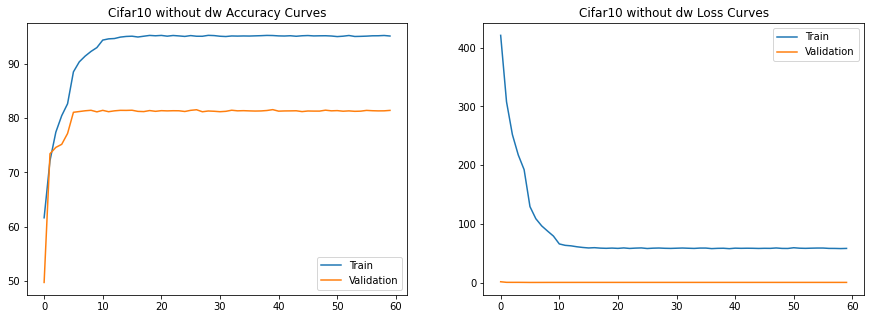

In [ ]:
plot_curves('Cifar10 without dw', n)

#### BASEMODEL  - 143 K PARAMETERS

In [ ]:
class CifarNet11(nn.Module):
    def __init__(self):
        super(CifarNet11, self).__init__()

# FIRST MAJOR BLOCK
        # first convolutional block
        self.convblock1a = nn.Sequential(
            nn.Conv2d(in_channels = 3,out_channels = 16, dilation  = 1,padding = 1, kernel_size= (3,3)),                     # in 32, out 32, RF 3
            nn.ReLU(),
            nn.BatchNorm2d(16)
        )

        self.convblock1b = nn.Sequential(
            nn.Conv2d(in_channels = 16,out_channels = 16, dilation  = 1,padding = 1, kernel_size= (3,3)),                     # in 32, out 32, RF 3
            nn.ReLU(),
            nn.BatchNorm2d(16)
        )
        self.dropout1  = nn.Sequential(nn.Dropout(0.06))

        # Using stride 2 without dilation instead of maxpooling
        self.convpool1 = nn.MaxPool2d(2, 2)


# SECOND MAJOR BLOCK
          # first convolutional block
        self.convblock2a = nn.Sequential(
            # nn.Conv2d(in_channels = 16,out_channels = 32, dilation  = 1,padding = 1,kernel_size= (3,3)),                    # in 16, out 16, RF ?
            nn.Conv2d(in_channels = 16,out_channels = 16,groups = 16, dilation  = 1,padding = 1,kernel_size= (3,3)),
            nn.Conv2d(in_channels = 16,out_channels = 32, dilation = 1,padding = 0,kernel_size= (1,1)), # 8, 8, 3  
            nn.ReLU(),
            nn.BatchNorm2d(32)
        ) # will the learning will be better in depth wise or in normal 3x3 convolutions?

        self.convblock2b = nn.Sequential(
            nn.Conv2d(in_channels = 32,out_channels = 32, dilation  = 1,padding = 1, kernel_size= (3,3)),                     # in 16, out 16, RF 3
            nn.ReLU(),
            nn.BatchNorm2d(32)
        )
        self.dropout2  = nn.Sequential(nn.Dropout(0.07))

        # Using stride 2 without dilation to simulate max pooling
        self.convpool2 = nn.MaxPool2d(2, 2)

# THIRD MAJOR BLOCK
         # first convolutional block
        self.convblock3a = nn.Sequential(
            # nn.Conv2d(in_channels = 32,out_channels = 64, dilation  = 1,padding = 1,kernel_size= (3,3)), 
            nn.Conv2d(in_channels = 32,out_channels = 32,groups = 32, dilation  = 1,padding = 1,kernel_size= (3,3)),        # in 8, out 8, RF ?
            nn.Conv2d(in_channels = 32,out_channels = 64, dilation = 1,padding = 0,kernel_size= (1,1)), # 8, 8, 3           # in 8, out 8, RF ?
            nn.ReLU(),
            nn.BatchNorm2d(64)
        )

        self.convblock3b = nn.Sequential(
            nn.Conv2d(in_channels = 64,out_channels = 64, dilation  = 2,padding = 2, kernel_size= (3,3)),                     # in 8, out 8, RF 3
            nn.ReLU(),
            nn.BatchNorm2d(64)
        )
        self.dropout3  = nn.Sequential(nn.Dropout(0.07))
        # using dilation to simulate maxpooling
        self.convpool3 = nn.MaxPool2d(2, 2)

# FOURTH MAJOR BLOCK
        # second convolutional block
        self.convblock4a = nn.Sequential(
            # nn.Conv2d(in_channels = 128,out_channels = 128, dilation  = 1,padding = 1,kernel_size= (3,3)), 
            nn.Conv2d(in_channels = 64,out_channels = 64, groups = 64, dilation  = 1,padding = 1,kernel_size= (3,3)),    # in 4, out 4, RF ?
            nn.Conv2d(in_channels = 64,out_channels = 128, dilation  = 1,padding = 0,kernel_size= (1,1)),                  # in 4, out 4, RF ?
            nn.ReLU(),
            nn.BatchNorm2d(128)
        )

        self.convblock4a1 = nn.Sequential(
            # nn.Conv2d(in_channels = 128,out_channels = 128, dilation  = 1,padding = 1,kernel_size= (3,3)), 
            nn.Conv2d(in_channels = 128,out_channels = 128, groups = 128, dilation  = 1,padding = 1,kernel_size= (3,3)),    # in 4, out 4,, RF ?
            nn.Conv2d(in_channels = 128,out_channels = 192, dilation  = 1,padding = 0,kernel_size= (1,1)),                  # in 4, out 4, RF ?
            nn.ReLU(),
            nn.BatchNorm2d(192)
        )

        self.dropout4  = nn.Sequential(nn.Dropout(0.05))

        self.convblock4b = nn.Sequential(
            # nn.Conv2d(in_channels = 128,out_channels = 128, dilation  = 1,padding = 1,kernel_size= (3,3)), 
            nn.Conv2d(in_channels = 192,out_channels = 192, groups = 192, dilation  = 1,padding = 1,kernel_size= (3,3)),    # in 4, out 4,, RF ?
            nn.Conv2d(in_channels = 192,out_channels = 260, dilation  = 1,padding = 0,kernel_size= (1,1)),                  # in 4, out 4, RF ?
            nn.ReLU(),
            nn.BatchNorm2d(260)
        )

        # self.convblock4b = nn.Sequential(
        #     # nn.Conv2d(in_channels = 128,out_channels = 128, dilation  = 1,padding = 1,kernel_size= (3,3)), 
        #     nn.Conv2d(in_channels = 128,out_channels = 128, groups = 128, dilation  = 1,padding = 1,kernel_size= (3,3)),    # in 4, out 4,, RF ?
        #     nn.Conv2d(in_channels = 128,out_channels = 256, dilation  = 1,padding = 0,kernel_size= (1,1)),                  # in 4, out 4, RF ?
        #     nn.ReLU(),
        #     nn.BatchNorm2d(256)
        # )

# GAP LAYER
        self.gap = nn.AvgPool2d(4)                                                                                          # in 3, out 1, RF ?
        self.convblockf = nn.Sequential(
            nn.Conv2d(in_channels=260, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) 


    def forward(self, x):
        x = self.convblock1a(x)
        x1 = self.convblock1b(x)
        x = torch.add(x,x1)
        x = self.dropout1(x)
        x = self.convpool1(x)


        x = self.convblock2a(x)
        x1 = self.convblock2b(x)
        x = torch.add(x,x1)
        x = self.dropout2(x)
        x = self.convpool2(x1)

        x = self.convblock3a(x)
        x1 = self.convblock3b(x)        
        x = torch.add(x,x1)
        x = self.dropout3(x)
        x = self.convpool3(x1)

        x = self.convblock4a(x)
        x = self.convblock4a1(x)
        x = self.dropout4(x)
        x = self.convblock4b(x)
        
        
        x = self.gap(x)
        x = self.convblockf(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)


In [ ]:
epochs = 100
device = "cuda"
model = CifarNet11().to(device)
summary(model, input_size=(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
              ReLU-2           [-1, 16, 32, 32]               0
       BatchNorm2d-3           [-1, 16, 32, 32]              32
            Conv2d-4           [-1, 16, 32, 32]           2,320
              ReLU-5           [-1, 16, 32, 32]               0
       BatchNorm2d-6           [-1, 16, 32, 32]              32
           Dropout-7           [-1, 16, 32, 32]               0
         MaxPool2d-8           [-1, 16, 16, 16]               0
            Conv2d-9           [-1, 16, 16, 16]             160
           Conv2d-10           [-1, 32, 16, 16]             544
             ReLU-11           [-1, 32, 16, 16]               0
      BatchNorm2d-12           [-1, 32, 16, 16]              64
           Conv2d-13           [-1, 32, 16, 16]           9,248
             ReLU-14           [-1, 32,

#### running subset experiments

In [ ]:
opt = optim.Adam(model.parameters(), lr = 0.01)
optimizer = SWA(opt, swa_start=10, swa_freq=5, swa_lr=0.005)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)
# scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.5, steps_per_epoch=len(train_loader), epochs=epochs)
path = './mos_ml_cif_100/normal_pytorch_dw_swapy.pth'
execute_model(model, save_best_model=True)

EPOCH: 0


  0%|          | 0/352 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Loss=1.0933270454406738 Batch_id=351 Accuracy=50.96: 100%|██████████| 352/352 [00:17<00:00, 19.94it/s]



Test set: Average loss: 2.9159, Accuracy: 1577/10000 (15.77%)

24.4 15.77
EPOCH: 1


Loss=0.8859544396400452 Batch_id=351 Accuracy=62.79: 100%|██████████| 352/352 [00:17<00:00, 20.01it/s]



Test set: Average loss: 1.8788, Accuracy: 3458/10000 (34.58%)

34.58 34.58
Saving model here
EPOCH: 2


Loss=0.7464849948883057 Batch_id=351 Accuracy=67.53: 100%|██████████| 352/352 [00:17<00:00, 20.10it/s]



Test set: Average loss: 1.2808, Accuracy: 5239/10000 (52.39%)

52.39 52.39
Saving model here
EPOCH: 3


Loss=0.6089948415756226 Batch_id=351 Accuracy=71.05: 100%|██████████| 352/352 [00:17<00:00, 19.67it/s]



Test set: Average loss: 1.2373, Accuracy: 5279/10000 (52.79%)

52.79 52.79
Saving model here
EPOCH: 4


Loss=0.8310836553573608 Batch_id=351 Accuracy=73.18: 100%|██████████| 352/352 [00:17<00:00, 19.61it/s]



Test set: Average loss: 1.2792, Accuracy: 5650/10000 (56.50%)

56.5 56.5
Saving model here
EPOCH: 5


Loss=0.9493310451507568 Batch_id=351 Accuracy=75.30: 100%|██████████| 352/352 [00:18<00:00, 19.45it/s]



Test set: Average loss: 1.1747, Accuracy: 5778/10000 (57.78%)

57.78 57.78
Saving model here
EPOCH: 6


Loss=0.9634047746658325 Batch_id=351 Accuracy=76.98: 100%|██████████| 352/352 [00:18<00:00, 19.55it/s]



Test set: Average loss: 0.8813, Accuracy: 6930/10000 (69.30%)

69.3 69.3
Saving model here
EPOCH: 7


Loss=0.6593295335769653 Batch_id=351 Accuracy=77.89: 100%|██████████| 352/352 [00:17<00:00, 19.68it/s]



Test set: Average loss: 1.3475, Accuracy: 5416/10000 (54.16%)

69.3 54.16
EPOCH: 8


Loss=0.8054046630859375 Batch_id=351 Accuracy=78.97: 100%|██████████| 352/352 [00:18<00:00, 19.48it/s]



Test set: Average loss: 1.0081, Accuracy: 6600/10000 (66.00%)

69.3 66.0
EPOCH: 9


Loss=0.5439879894256592 Batch_id=351 Accuracy=79.98: 100%|██████████| 352/352 [00:17<00:00, 19.58it/s]



Test set: Average loss: 1.1229, Accuracy: 5996/10000 (59.96%)

69.3 59.96
EPOCH: 10


Loss=0.7482272982597351 Batch_id=351 Accuracy=80.66: 100%|██████████| 352/352 [00:18<00:00, 19.32it/s]



Test set: Average loss: 1.0189, Accuracy: 6600/10000 (66.00%)

69.3 66.0
EPOCH: 11


Loss=0.4419521689414978 Batch_id=351 Accuracy=81.86: 100%|██████████| 352/352 [00:18<00:00, 19.34it/s]



Test set: Average loss: 1.0349, Accuracy: 6586/10000 (65.86%)

69.3 65.86
EPOCH: 12


Loss=0.6331961154937744 Batch_id=351 Accuracy=82.38: 100%|██████████| 352/352 [00:18<00:00, 19.08it/s]



Test set: Average loss: 0.7204, Accuracy: 7491/10000 (74.91%)

74.91 74.91
Saving model here
EPOCH: 13


Loss=0.36834216117858887 Batch_id=351 Accuracy=83.02: 100%|██████████| 352/352 [00:18<00:00, 19.10it/s]



Test set: Average loss: 1.5131, Accuracy: 5859/10000 (58.59%)

74.91 58.59
EPOCH: 14


Loss=0.5711259245872498 Batch_id=351 Accuracy=83.86: 100%|██████████| 352/352 [00:18<00:00, 19.10it/s]



Test set: Average loss: 1.0414, Accuracy: 6577/10000 (65.77%)

74.91 65.77
EPOCH: 15


Loss=0.4451284408569336 Batch_id=351 Accuracy=84.40: 100%|██████████| 352/352 [00:18<00:00, 18.99it/s]



Test set: Average loss: 1.2068, Accuracy: 6323/10000 (63.23%)

74.91 63.23
EPOCH: 16


Loss=0.38672855496406555 Batch_id=351 Accuracy=84.88: 100%|██████████| 352/352 [00:18<00:00, 19.02it/s]



Test set: Average loss: 0.8994, Accuracy: 7206/10000 (72.06%)

74.91 72.06
EPOCH: 17


Loss=0.3653290569782257 Batch_id=351 Accuracy=85.64: 100%|██████████| 352/352 [00:18<00:00, 19.28it/s]



Test set: Average loss: 0.9374, Accuracy: 7124/10000 (71.24%)

74.91 71.24
EPOCH: 18


Loss=0.38152560591697693 Batch_id=351 Accuracy=86.15: 100%|██████████| 352/352 [00:18<00:00, 19.30it/s]



Test set: Average loss: 1.1335, Accuracy: 6532/10000 (65.32%)

74.91 65.32
EPOCH: 19


Loss=0.38636404275894165 Batch_id=351 Accuracy=86.78: 100%|██████████| 352/352 [00:17<00:00, 19.61it/s]



Test set: Average loss: 1.3890, Accuracy: 6231/10000 (62.31%)

74.91 62.31
EPOCH: 20


Loss=0.2548184394836426 Batch_id=351 Accuracy=87.42: 100%|██████████| 352/352 [00:17<00:00, 19.62it/s]



Test set: Average loss: 0.8385, Accuracy: 7422/10000 (74.22%)

74.91 74.22
EPOCH: 21


Loss=0.37421590089797974 Batch_id=351 Accuracy=87.86: 100%|██████████| 352/352 [00:18<00:00, 19.46it/s]



Test set: Average loss: 1.0036, Accuracy: 6916/10000 (69.16%)

74.91 69.16
EPOCH: 22


Loss=0.22049686312675476 Batch_id=351 Accuracy=88.29: 100%|██████████| 352/352 [00:18<00:00, 19.49it/s]



Test set: Average loss: 1.0625, Accuracy: 7018/10000 (70.18%)

74.91 70.18
EPOCH: 23


Loss=0.4643462896347046 Batch_id=351 Accuracy=88.51: 100%|██████████| 352/352 [00:17<00:00, 19.67it/s]



Test set: Average loss: 1.1558, Accuracy: 6752/10000 (67.52%)

74.91 67.52
EPOCH: 24


Loss=0.336742639541626 Batch_id=351 Accuracy=88.92: 100%|██████████| 352/352 [00:17<00:00, 19.60it/s]



Test set: Average loss: 0.9060, Accuracy: 7370/10000 (73.70%)

74.91 73.7
EPOCH: 25


Loss=0.4088832139968872 Batch_id=351 Accuracy=89.49: 100%|██████████| 352/352 [00:17<00:00, 19.69it/s]



Test set: Average loss: 1.2909, Accuracy: 6722/10000 (67.22%)

74.91 67.22
EPOCH: 26


Loss=0.3957628905773163 Batch_id=351 Accuracy=89.92: 100%|██████████| 352/352 [00:18<00:00, 19.25it/s]



Test set: Average loss: 1.1053, Accuracy: 7044/10000 (70.44%)

74.91 70.44
EPOCH: 27


Loss=0.6240174770355225 Batch_id=351 Accuracy=90.08: 100%|██████████| 352/352 [00:18<00:00, 19.32it/s]



Test set: Average loss: 1.8482, Accuracy: 5779/10000 (57.79%)

74.91 57.79
EPOCH: 28


Loss=0.634224534034729 Batch_id=351 Accuracy=90.18: 100%|██████████| 352/352 [00:18<00:00, 19.42it/s]



Test set: Average loss: 1.1594, Accuracy: 6914/10000 (69.14%)

74.91 69.14
EPOCH: 29


Loss=0.4917593002319336 Batch_id=351 Accuracy=91.06: 100%|██████████| 352/352 [00:18<00:00, 19.32it/s]



Test set: Average loss: 1.4022, Accuracy: 6594/10000 (65.94%)

74.91 65.94
EPOCH: 30


Loss=0.2891203463077545 Batch_id=351 Accuracy=91.07: 100%|██████████| 352/352 [00:18<00:00, 19.14it/s]



Test set: Average loss: 1.3572, Accuracy: 6750/10000 (67.50%)

74.91 67.5
EPOCH: 31


Loss=0.3384592533111572 Batch_id=351 Accuracy=91.77: 100%|██████████| 352/352 [00:18<00:00, 19.33it/s]



Test set: Average loss: 1.3599, Accuracy: 6544/10000 (65.44%)

74.91 65.44
EPOCH: 32


Loss=0.1961010992527008 Batch_id=351 Accuracy=91.72: 100%|██████████| 352/352 [00:18<00:00, 18.90it/s]



Test set: Average loss: 1.1472, Accuracy: 7211/10000 (72.11%)

74.91 72.11
EPOCH: 33


Loss=0.14827214181423187 Batch_id=351 Accuracy=91.89: 100%|██████████| 352/352 [00:18<00:00, 18.92it/s]



Test set: Average loss: 1.0076, Accuracy: 7305/10000 (73.05%)

74.91 73.05
EPOCH: 34


Loss=0.2222083956003189 Batch_id=351 Accuracy=92.08: 100%|██████████| 352/352 [00:18<00:00, 19.06it/s]



Test set: Average loss: 1.2213, Accuracy: 6986/10000 (69.86%)

74.91 69.86
EPOCH: 35


Loss=0.33073103427886963 Batch_id=351 Accuracy=92.40: 100%|██████████| 352/352 [00:18<00:00, 18.78it/s]



Test set: Average loss: 1.8066, Accuracy: 6398/10000 (63.98%)

74.91 63.98
EPOCH: 36


Loss=0.39078426361083984 Batch_id=351 Accuracy=92.88: 100%|██████████| 352/352 [00:18<00:00, 18.73it/s]



Test set: Average loss: 1.4132, Accuracy: 6698/10000 (66.98%)

74.91 66.98
EPOCH: 37


Loss=0.283027708530426 Batch_id=351 Accuracy=93.14: 100%|██████████| 352/352 [00:18<00:00, 18.85it/s]



Test set: Average loss: 1.2655, Accuracy: 7067/10000 (70.67%)

74.91 70.67
EPOCH: 38


Loss=0.29442036151885986 Batch_id=351 Accuracy=93.22: 100%|██████████| 352/352 [00:18<00:00, 18.81it/s]



Test set: Average loss: 1.0816, Accuracy: 7307/10000 (73.07%)

74.91 73.07
EPOCH: 39


Loss=0.22354228794574738 Batch_id=351 Accuracy=93.53: 100%|██████████| 352/352 [00:19<00:00, 18.41it/s]



Test set: Average loss: 1.3714, Accuracy: 6933/10000 (69.33%)

74.91 69.33
EPOCH: 40


Loss=0.24058397114276886 Batch_id=351 Accuracy=93.01: 100%|██████████| 352/352 [00:19<00:00, 18.33it/s]



Test set: Average loss: 1.5048, Accuracy: 6881/10000 (68.81%)

74.91 68.81
EPOCH: 41


Loss=0.17448687553405762 Batch_id=351 Accuracy=93.86: 100%|██████████| 352/352 [00:18<00:00, 18.65it/s]



Test set: Average loss: 1.2865, Accuracy: 7155/10000 (71.55%)

74.91 71.55
EPOCH: 42


Loss=0.16255639493465424 Batch_id=351 Accuracy=93.74: 100%|██████████| 352/352 [00:18<00:00, 19.32it/s]



Test set: Average loss: 1.5298, Accuracy: 6818/10000 (68.18%)

74.91 68.18
EPOCH: 43


Loss=0.10902644693851471 Batch_id=351 Accuracy=94.22: 100%|██████████| 352/352 [00:18<00:00, 19.15it/s]



Test set: Average loss: 1.2563, Accuracy: 7209/10000 (72.09%)

74.91 72.09
EPOCH: 44


Loss=0.2690424919128418 Batch_id=351 Accuracy=94.04: 100%|██████████| 352/352 [00:18<00:00, 19.20it/s]



Test set: Average loss: 1.1538, Accuracy: 7460/10000 (74.60%)

74.91 74.6
EPOCH: 45


Loss=0.13296449184417725 Batch_id=351 Accuracy=94.07: 100%|██████████| 352/352 [00:18<00:00, 19.40it/s]



Test set: Average loss: 1.1832, Accuracy: 7287/10000 (72.87%)

74.91 72.87
EPOCH: 46


Loss=0.1353698968887329 Batch_id=351 Accuracy=94.36: 100%|██████████| 352/352 [00:18<00:00, 19.12it/s]



Test set: Average loss: 1.3670, Accuracy: 7123/10000 (71.23%)

74.91 71.23
EPOCH: 47


Loss=0.2903216481208801 Batch_id=351 Accuracy=94.36: 100%|██████████| 352/352 [00:18<00:00, 18.93it/s]



Test set: Average loss: 1.4666, Accuracy: 6946/10000 (69.46%)

74.91 69.46
EPOCH: 48


Loss=0.37991681694984436 Batch_id=351 Accuracy=94.33: 100%|██████████| 352/352 [00:18<00:00, 18.61it/s]



Test set: Average loss: 1.8064, Accuracy: 6871/10000 (68.71%)

74.91 68.71
EPOCH: 49


Loss=0.17211103439331055 Batch_id=351 Accuracy=94.51: 100%|██████████| 352/352 [00:18<00:00, 19.30it/s]



Test set: Average loss: 1.5599, Accuracy: 6683/10000 (66.83%)

74.91 66.83
EPOCH: 50


Loss=0.1500830352306366 Batch_id=351 Accuracy=94.71: 100%|██████████| 352/352 [00:18<00:00, 19.10it/s]



Test set: Average loss: 1.3082, Accuracy: 7388/10000 (73.88%)

74.91 73.88
EPOCH: 51


Loss=0.13818621635437012 Batch_id=351 Accuracy=94.96: 100%|██████████| 352/352 [00:18<00:00, 19.01it/s]



Test set: Average loss: 1.1719, Accuracy: 7292/10000 (72.92%)

74.91 72.92
EPOCH: 52


Loss=0.22745810449123383 Batch_id=351 Accuracy=94.85: 100%|██████████| 352/352 [00:18<00:00, 19.06it/s]



Test set: Average loss: 1.4344, Accuracy: 7120/10000 (71.20%)

74.91 71.2
EPOCH: 53


Loss=0.26943838596343994 Batch_id=351 Accuracy=95.00: 100%|██████████| 352/352 [00:18<00:00, 18.76it/s]



Test set: Average loss: 1.3005, Accuracy: 7300/10000 (73.00%)

74.91 73.0
EPOCH: 54


Loss=0.19421686232089996 Batch_id=351 Accuracy=95.06: 100%|██████████| 352/352 [00:18<00:00, 18.70it/s]



Test set: Average loss: 1.4057, Accuracy: 7369/10000 (73.69%)

74.91 73.69
EPOCH: 55


Loss=0.1769006848335266 Batch_id=351 Accuracy=95.36: 100%|██████████| 352/352 [00:18<00:00, 18.87it/s]



Test set: Average loss: 1.2974, Accuracy: 7195/10000 (71.95%)

74.91 71.95
EPOCH: 56


Loss=0.1681615263223648 Batch_id=351 Accuracy=95.24: 100%|██████████| 352/352 [00:18<00:00, 19.17it/s]



Test set: Average loss: 1.8602, Accuracy: 6771/10000 (67.71%)

74.91 67.71
EPOCH: 57


Loss=0.1629318743944168 Batch_id=351 Accuracy=95.48: 100%|██████████| 352/352 [00:18<00:00, 19.22it/s]



Test set: Average loss: 1.7502, Accuracy: 6823/10000 (68.23%)

74.91 68.23
EPOCH: 58


Loss=0.10875338315963745 Batch_id=351 Accuracy=95.53: 100%|██████████| 352/352 [00:18<00:00, 19.05it/s]



Test set: Average loss: 1.7127, Accuracy: 6923/10000 (69.23%)

74.91 69.23
EPOCH: 59


Loss=0.19771136343479156 Batch_id=351 Accuracy=95.62: 100%|██████████| 352/352 [00:18<00:00, 19.33it/s]



Test set: Average loss: 1.6041, Accuracy: 6904/10000 (69.04%)

74.91 69.04
EPOCH: 60


Loss=0.12140616029500961 Batch_id=351 Accuracy=95.41: 100%|██████████| 352/352 [00:18<00:00, 18.72it/s]



Test set: Average loss: 1.8892, Accuracy: 6823/10000 (68.23%)

74.91 68.23
EPOCH: 61


Loss=0.25039684772491455 Batch_id=351 Accuracy=95.84: 100%|██████████| 352/352 [00:18<00:00, 18.74it/s]



Test set: Average loss: 1.9272, Accuracy: 6531/10000 (65.31%)

74.91 65.31
EPOCH: 62


Loss=0.19698652625083923 Batch_id=351 Accuracy=95.72: 100%|██████████| 352/352 [00:18<00:00, 18.54it/s]



Test set: Average loss: 1.3440, Accuracy: 7277/10000 (72.77%)

74.91 72.77
EPOCH: 63


Loss=0.13655336201190948 Batch_id=351 Accuracy=95.67: 100%|██████████| 352/352 [00:19<00:00, 18.52it/s]



Test set: Average loss: 1.4795, Accuracy: 7245/10000 (72.45%)

74.91 72.45
EPOCH: 64


Loss=0.12955260276794434 Batch_id=351 Accuracy=96.21: 100%|██████████| 352/352 [00:18<00:00, 18.54it/s]



Test set: Average loss: 1.6718, Accuracy: 7147/10000 (71.47%)

74.91 71.47
EPOCH: 65


Loss=0.1199164018034935 Batch_id=351 Accuracy=95.85: 100%|██████████| 352/352 [00:18<00:00, 18.59it/s]



Test set: Average loss: 1.4983, Accuracy: 7109/10000 (71.09%)

74.91 71.09
EPOCH: 66


Loss=0.273157000541687 Batch_id=351 Accuracy=95.93: 100%|██████████| 352/352 [00:18<00:00, 18.77it/s]



Test set: Average loss: 1.6152, Accuracy: 7152/10000 (71.52%)

74.91 71.52
EPOCH: 67


Loss=0.11563335359096527 Batch_id=351 Accuracy=95.60: 100%|██████████| 352/352 [00:18<00:00, 18.60it/s]



Test set: Average loss: 1.9033, Accuracy: 6727/10000 (67.27%)

74.91 67.27
EPOCH: 68


Loss=0.1635318249464035 Batch_id=351 Accuracy=96.23: 100%|██████████| 352/352 [00:18<00:00, 18.89it/s]



Test set: Average loss: 1.2866, Accuracy: 7389/10000 (73.89%)

74.91 73.89
EPOCH: 69


Loss=0.07613280415534973 Batch_id=80 Accuracy=97.00:  23%|██▎       | 81/352 [00:04<00:15, 17.70it/s]Exception in thread Thread-178:
Traceback (most recent call last):
  File "/usr/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/_utils/pin_memory.py", line 28, in _pin_memory_loop
    r = in_queue.get(timeout=MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 113, in get
    return _ForkingPickler.loads(res)
  File "/usr/local/lib/python3.7/dist-packages/torch/multiprocessing/reductions.py", line 289, in rebuild_storage_fd
    fd = df.detach()
  File "/usr/lib/python3.7/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/usr/lib/python3.7/multiprocessing/resource_sharer.py", line 87, in ge

KeyboardInterrupt: ignored

#### running one cycle experiments

In [ ]:
optimizer = optim.Adam(model.parameters(), lr = 0.01)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.5, steps_per_epoch=len(train_loader), epochs=epochs)
path = './mos_ml_cif_100/normal_pytorch_dw_onecycle.pth'
execute_model(model, save_best_model=True)

EPOCH: 0


  0%|          | 0/391 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Loss=1.1235744953155518 Batch_id=390 Accuracy=47.70: 100%|██████████| 391/391 [00:13<00:00, 28.35it/s]



Test set: Average loss: 1.2340, Accuracy: 5672/10000 (56.72%)

56.72 56.72
Saving model here
EPOCH: 1


Loss=0.8570682406425476 Batch_id=390 Accuracy=64.59: 100%|██████████| 391/391 [00:13<00:00, 29.03it/s]



Test set: Average loss: 1.0797, Accuracy: 6442/10000 (64.42%)

64.42 64.42
Saving model here
EPOCH: 2


Loss=0.8813544511795044 Batch_id=390 Accuracy=70.54: 100%|██████████| 391/391 [00:13<00:00, 28.19it/s]



Test set: Average loss: 0.9501, Accuracy: 6756/10000 (67.56%)

67.56 67.56
Saving model here
EPOCH: 3


Loss=0.7308955788612366 Batch_id=390 Accuracy=74.63: 100%|██████████| 391/391 [00:14<00:00, 27.58it/s]



Test set: Average loss: 0.8291, Accuracy: 7138/10000 (71.38%)

71.38 71.38
Saving model here
EPOCH: 4


Loss=0.8272210955619812 Batch_id=390 Accuracy=76.82: 100%|██████████| 391/391 [00:13<00:00, 29.05it/s]



Test set: Average loss: 0.7230, Accuracy: 7514/10000 (75.14%)

75.14 75.14
Saving model here
EPOCH: 5


Loss=0.6136372685432434 Batch_id=390 Accuracy=78.75: 100%|██████████| 391/391 [00:13<00:00, 28.01it/s]



Test set: Average loss: 0.8364, Accuracy: 7208/10000 (72.08%)

75.14 72.08
EPOCH: 6


Loss=0.5492459535598755 Batch_id=390 Accuracy=80.01: 100%|██████████| 391/391 [00:13<00:00, 28.09it/s]



Test set: Average loss: 0.7162, Accuracy: 7620/10000 (76.20%)

76.2 76.2
Saving model here
EPOCH: 7


Loss=0.5640535950660706 Batch_id=390 Accuracy=81.65: 100%|██████████| 391/391 [00:13<00:00, 28.22it/s]



Test set: Average loss: 0.6858, Accuracy: 7684/10000 (76.84%)

76.84 76.84
Saving model here
EPOCH: 8


Loss=0.4165072441101074 Batch_id=390 Accuracy=82.70: 100%|██████████| 391/391 [00:13<00:00, 28.06it/s]



Test set: Average loss: 0.6837, Accuracy: 7726/10000 (77.26%)

77.26 77.26
Saving model here
EPOCH: 9


Loss=0.5069897770881653 Batch_id=390 Accuracy=84.02: 100%|██████████| 391/391 [00:14<00:00, 27.49it/s]



Test set: Average loss: 0.6791, Accuracy: 7839/10000 (78.39%)

78.39 78.39
Saving model here
EPOCH: 10


Loss=0.37082159519195557 Batch_id=390 Accuracy=84.68: 100%|██████████| 391/391 [00:14<00:00, 27.60it/s]



Test set: Average loss: 0.7063, Accuracy: 7748/10000 (77.48%)

78.39 77.48
EPOCH: 11


Loss=0.540791928768158 Batch_id=390 Accuracy=85.97: 100%|██████████| 391/391 [00:13<00:00, 28.09it/s]



Test set: Average loss: 0.7278, Accuracy: 7700/10000 (77.00%)

78.39 77.0
EPOCH: 12


Loss=0.347390353679657 Batch_id=390 Accuracy=86.29: 100%|██████████| 391/391 [00:13<00:00, 28.87it/s]



Test set: Average loss: 0.7192, Accuracy: 7706/10000 (77.06%)

78.39 77.06
EPOCH: 13


Loss=0.41343194246292114 Batch_id=390 Accuracy=87.01: 100%|██████████| 391/391 [00:13<00:00, 28.63it/s]



Test set: Average loss: 0.8265, Accuracy: 7512/10000 (75.12%)

78.39 75.12
EPOCH: 14


Loss=0.4480651319026947 Batch_id=390 Accuracy=87.88: 100%|██████████| 391/391 [00:14<00:00, 27.04it/s]



Test set: Average loss: 0.7220, Accuracy: 7808/10000 (78.08%)

78.39 78.08
EPOCH: 15


Loss=0.3499918580055237 Batch_id=390 Accuracy=88.76: 100%|██████████| 391/391 [00:14<00:00, 27.28it/s]



Test set: Average loss: 0.7066, Accuracy: 7846/10000 (78.46%)

78.46 78.46
Saving model here
EPOCH: 16


Loss=0.25341731309890747 Batch_id=390 Accuracy=89.08: 100%|██████████| 391/391 [00:13<00:00, 28.39it/s]



Test set: Average loss: 0.7459, Accuracy: 7818/10000 (78.18%)

78.46 78.18
EPOCH: 17


Loss=0.1926177442073822 Batch_id=390 Accuracy=89.72: 100%|██████████| 391/391 [00:13<00:00, 28.97it/s]



Test set: Average loss: 0.7697, Accuracy: 7808/10000 (78.08%)

78.46 78.08
EPOCH: 18


Loss=0.36152535676956177 Batch_id=390 Accuracy=90.32: 100%|██████████| 391/391 [00:14<00:00, 26.60it/s]



Test set: Average loss: 0.7697, Accuracy: 7895/10000 (78.95%)

78.95 78.95
Saving model here
EPOCH: 19


Loss=0.28221482038497925 Batch_id=390 Accuracy=90.99: 100%|██████████| 391/391 [00:14<00:00, 26.91it/s]



Test set: Average loss: 0.8958, Accuracy: 7628/10000 (76.28%)

78.95 76.28
EPOCH: 20


Loss=0.25091326236724854 Batch_id=390 Accuracy=91.24: 100%|██████████| 391/391 [00:14<00:00, 27.78it/s]



Test set: Average loss: 0.7982, Accuracy: 7820/10000 (78.20%)

78.95 78.2
EPOCH: 21


Loss=0.44746842980384827 Batch_id=390 Accuracy=91.49: 100%|██████████| 391/391 [00:13<00:00, 28.40it/s]



Test set: Average loss: 0.8632, Accuracy: 7723/10000 (77.23%)

78.95 77.23
EPOCH: 22


Loss=0.3919847309589386 Batch_id=390 Accuracy=91.80: 100%|██████████| 391/391 [00:14<00:00, 27.79it/s]



Test set: Average loss: 0.8348, Accuracy: 7809/10000 (78.09%)

78.95 78.09
EPOCH: 23


Loss=0.2673737108707428 Batch_id=390 Accuracy=92.32: 100%|██████████| 391/391 [00:14<00:00, 27.60it/s]



Test set: Average loss: 0.8707, Accuracy: 7719/10000 (77.19%)

78.95 77.19
EPOCH: 24


Loss=0.14645281434059143 Batch_id=390 Accuracy=93.00: 100%|██████████| 391/391 [00:13<00:00, 28.65it/s]



Test set: Average loss: 0.8326, Accuracy: 7902/10000 (79.02%)

79.02 79.02
Saving model here
EPOCH: 25


Loss=0.2274172604084015 Batch_id=390 Accuracy=93.03: 100%|██████████| 391/391 [00:13<00:00, 28.26it/s]



Test set: Average loss: 0.9308, Accuracy: 7763/10000 (77.63%)

79.02 77.63
EPOCH: 26


Loss=0.19377915561199188 Batch_id=390 Accuracy=93.35: 100%|██████████| 391/391 [00:14<00:00, 26.93it/s]



Test set: Average loss: 0.8742, Accuracy: 7861/10000 (78.61%)

79.02 78.61
EPOCH: 27


Loss=0.08233906328678131 Batch_id=390 Accuracy=93.77: 100%|██████████| 391/391 [00:14<00:00, 27.64it/s]



Test set: Average loss: 0.9309, Accuracy: 7839/10000 (78.39%)

79.02 78.39
EPOCH: 28


Loss=0.20031540095806122 Batch_id=390 Accuracy=93.78: 100%|██████████| 391/391 [00:14<00:00, 27.37it/s]



Test set: Average loss: 0.9133, Accuracy: 7839/10000 (78.39%)

79.02 78.39
EPOCH: 29


Loss=0.18212983012199402 Batch_id=390 Accuracy=94.04: 100%|██████████| 391/391 [00:14<00:00, 27.45it/s]



Test set: Average loss: 0.9649, Accuracy: 7802/10000 (78.02%)

79.02 78.02
EPOCH: 30


Loss=0.2325809746980667 Batch_id=390 Accuracy=94.18: 100%|██████████| 391/391 [00:14<00:00, 27.46it/s]



Test set: Average loss: 0.9331, Accuracy: 7849/10000 (78.49%)

79.02 78.49
EPOCH: 31


Loss=0.2253975123167038 Batch_id=390 Accuracy=94.78: 100%|██████████| 391/391 [00:14<00:00, 27.47it/s]



Test set: Average loss: 1.0310, Accuracy: 7739/10000 (77.39%)

79.02 77.39
EPOCH: 32


Loss=0.0962899774312973 Batch_id=390 Accuracy=94.69: 100%|██████████| 391/391 [00:14<00:00, 27.42it/s]



Test set: Average loss: 0.9427, Accuracy: 7899/10000 (78.99%)

79.02 78.99
EPOCH: 33


Loss=0.20939263701438904 Batch_id=390 Accuracy=94.51: 100%|██████████| 391/391 [00:14<00:00, 27.85it/s]



Test set: Average loss: 0.9603, Accuracy: 7873/10000 (78.73%)

79.02 78.73
EPOCH: 34


Loss=0.2604166865348816 Batch_id=390 Accuracy=95.00: 100%|██████████| 391/391 [00:14<00:00, 27.83it/s]



Test set: Average loss: 0.9792, Accuracy: 7834/10000 (78.34%)

79.02 78.34
EPOCH: 35


Loss=0.12422935664653778 Batch_id=390 Accuracy=95.12: 100%|██████████| 391/391 [00:14<00:00, 27.08it/s]



Test set: Average loss: 1.0190, Accuracy: 7818/10000 (78.18%)

79.02 78.18
EPOCH: 36


Loss=0.1524447798728943 Batch_id=390 Accuracy=95.20: 100%|██████████| 391/391 [00:14<00:00, 27.59it/s]



Test set: Average loss: 0.9993, Accuracy: 7810/10000 (78.10%)

79.02 78.1
EPOCH: 37


Loss=0.22442874312400818 Batch_id=390 Accuracy=95.51: 100%|██████████| 391/391 [00:14<00:00, 26.27it/s]



Test set: Average loss: 1.0992, Accuracy: 7759/10000 (77.59%)

79.02 77.59
EPOCH: 38


Loss=0.058272309601306915 Batch_id=390 Accuracy=95.36: 100%|██████████| 391/391 [00:14<00:00, 26.78it/s]



Test set: Average loss: 1.0290, Accuracy: 7843/10000 (78.43%)

79.02 78.43
EPOCH: 39


Loss=0.12960952520370483 Batch_id=390 Accuracy=95.60: 100%|██████████| 391/391 [00:15<00:00, 25.81it/s]



Test set: Average loss: 1.0706, Accuracy: 7871/10000 (78.71%)

79.02 78.71
EPOCH: 40


Loss=0.10568822920322418 Batch_id=390 Accuracy=95.62: 100%|██████████| 391/391 [00:15<00:00, 25.85it/s]



Test set: Average loss: 1.1146, Accuracy: 7834/10000 (78.34%)

79.02 78.34
EPOCH: 41


Loss=0.1030181497335434 Batch_id=390 Accuracy=95.45: 100%|██████████| 391/391 [00:14<00:00, 26.55it/s]



Test set: Average loss: 1.0909, Accuracy: 7889/10000 (78.89%)

79.02 78.89
EPOCH: 42


Loss=0.05596128851175308 Batch_id=390 Accuracy=96.08: 100%|██████████| 391/391 [00:14<00:00, 27.02it/s]



Test set: Average loss: 1.1096, Accuracy: 7901/10000 (79.01%)

79.02 79.01
EPOCH: 43


Loss=0.12076860666275024 Batch_id=390 Accuracy=96.31: 100%|██████████| 391/391 [00:14<00:00, 26.62it/s]



Test set: Average loss: 1.1641, Accuracy: 7732/10000 (77.32%)

79.02 77.32
EPOCH: 44


Loss=0.06515838950872421 Batch_id=390 Accuracy=95.93: 100%|██████████| 391/391 [00:14<00:00, 27.31it/s]



Test set: Average loss: 1.1155, Accuracy: 7886/10000 (78.86%)

79.02 78.86
EPOCH: 45


Loss=0.2595159411430359 Batch_id=390 Accuracy=96.24: 100%|██████████| 391/391 [00:14<00:00, 27.04it/s]



Test set: Average loss: 1.1423, Accuracy: 7817/10000 (78.17%)

79.02 78.17
EPOCH: 46


Loss=0.1278245747089386 Batch_id=390 Accuracy=95.93: 100%|██████████| 391/391 [00:15<00:00, 26.00it/s]



Test set: Average loss: 1.1881, Accuracy: 7763/10000 (77.63%)

79.02 77.63
EPOCH: 47


Loss=0.154936283826828 Batch_id=390 Accuracy=96.13: 100%|██████████| 391/391 [00:14<00:00, 26.72it/s]



Test set: Average loss: 1.1285, Accuracy: 7880/10000 (78.80%)

79.02 78.8
EPOCH: 48


Loss=0.09076594561338425 Batch_id=390 Accuracy=96.34: 100%|██████████| 391/391 [00:14<00:00, 27.38it/s]



Test set: Average loss: 1.1601, Accuracy: 7912/10000 (79.12%)

79.12 79.12
Saving model here
EPOCH: 49


Loss=0.08698958158493042 Batch_id=390 Accuracy=96.36: 100%|██████████| 391/391 [00:14<00:00, 27.01it/s]



Test set: Average loss: 1.1091, Accuracy: 7867/10000 (78.67%)

79.12 78.67
EPOCH: 50


Loss=0.17301180958747864 Batch_id=390 Accuracy=96.77: 100%|██████████| 391/391 [00:14<00:00, 27.21it/s]



Test set: Average loss: 1.1399, Accuracy: 7869/10000 (78.69%)

79.12 78.69
EPOCH: 51


Loss=0.12455382198095322 Batch_id=390 Accuracy=96.71: 100%|██████████| 391/391 [00:14<00:00, 27.07it/s]



Test set: Average loss: 1.2189, Accuracy: 7865/10000 (78.65%)

79.12 78.65
EPOCH: 52


Loss=0.12630829215049744 Batch_id=390 Accuracy=96.55: 100%|██████████| 391/391 [00:14<00:00, 26.48it/s]



Test set: Average loss: 1.1633, Accuracy: 7815/10000 (78.15%)

79.12 78.15
EPOCH: 53


Loss=0.09900347888469696 Batch_id=390 Accuracy=96.53: 100%|██████████| 391/391 [00:15<00:00, 26.04it/s]



Test set: Average loss: 1.1441, Accuracy: 7942/10000 (79.42%)

79.42 79.42
Saving model here
EPOCH: 54


Loss=0.20697899162769318 Batch_id=390 Accuracy=96.95: 100%|██████████| 391/391 [00:14<00:00, 27.00it/s]



Test set: Average loss: 1.1885, Accuracy: 7911/10000 (79.11%)

79.42 79.11
EPOCH: 55


Loss=0.2778324484825134 Batch_id=390 Accuracy=96.35: 100%|██████████| 391/391 [00:14<00:00, 26.73it/s]



Test set: Average loss: 1.2399, Accuracy: 7819/10000 (78.19%)

79.42 78.19
EPOCH: 56


Loss=0.040701717138290405 Batch_id=390 Accuracy=96.87: 100%|██████████| 391/391 [00:14<00:00, 27.12it/s]



Test set: Average loss: 1.2111, Accuracy: 7889/10000 (78.89%)

79.42 78.89
EPOCH: 57


Loss=0.1119556650519371 Batch_id=390 Accuracy=97.09: 100%|██████████| 391/391 [00:14<00:00, 27.06it/s]



Test set: Average loss: 1.1971, Accuracy: 7882/10000 (78.82%)

79.42 78.82
EPOCH: 58


Loss=0.026087969541549683 Batch_id=390 Accuracy=96.83: 100%|██████████| 391/391 [00:14<00:00, 26.42it/s]



Test set: Average loss: 1.2776, Accuracy: 7864/10000 (78.64%)

79.42 78.64
EPOCH: 59


Loss=0.0884515717625618 Batch_id=390 Accuracy=96.87: 100%|██████████| 391/391 [00:14<00:00, 26.55it/s]



Test set: Average loss: 1.2509, Accuracy: 7828/10000 (78.28%)

79.42 78.28


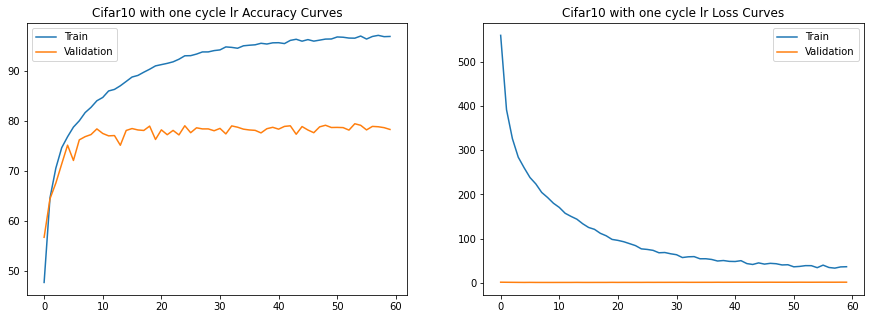

In [ ]:
plot_curves('Cifar10 with one cycle lr', model)

#### Running depthwise experiments

In [ ]:
optimizer = optim.Adam(model.parameters(), lr = 0.01)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)
path = './mos_ml_cif_100/normal_pytorch_dw.pth'
execute_model(model, save_best_model=True)

EPOCH: 0


  0%|          | 0/391 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Loss=0.9366692304611206 Batch_id=390 Accuracy=52.41: 100%|██████████| 391/391 [00:13<00:00, 29.44it/s]



Test set: Average loss: 1.0516, Accuracy: 6317/10000 (63.17%)

63.17 63.17
Saving model here
EPOCH: 1


Loss=0.881729245185852 Batch_id=390 Accuracy=68.36: 100%|██████████| 391/391 [00:13<00:00, 28.79it/s]



Test set: Average loss: 0.8967, Accuracy: 6890/10000 (68.90%)

68.9 68.9
Saving model here
EPOCH: 2


Loss=0.8097537755966187 Batch_id=390 Accuracy=73.81: 100%|██████████| 391/391 [00:13<00:00, 29.88it/s]



Test set: Average loss: 0.7890, Accuracy: 7262/10000 (72.62%)

72.62 72.62
Saving model here
EPOCH: 3


Loss=0.6433908343315125 Batch_id=390 Accuracy=76.58: 100%|██████████| 391/391 [00:12<00:00, 30.09it/s]



Test set: Average loss: 0.8259, Accuracy: 7218/10000 (72.18%)

72.62 72.18
EPOCH: 4


Loss=0.474649578332901 Batch_id=390 Accuracy=78.57: 100%|██████████| 391/391 [00:13<00:00, 29.97it/s]



Test set: Average loss: 0.6977, Accuracy: 7581/10000 (75.81%)

75.81 75.81
Saving model here
EPOCH: 5


Loss=0.4216550886631012 Batch_id=390 Accuracy=84.99: 100%|██████████| 391/391 [00:12<00:00, 30.32it/s]



Test set: Average loss: 0.6104, Accuracy: 7937/10000 (79.37%)

79.37 79.37
Saving model here
EPOCH: 6


Loss=0.24693408608436584 Batch_id=390 Accuracy=87.03: 100%|██████████| 391/391 [00:12<00:00, 30.82it/s]



Test set: Average loss: 0.6127, Accuracy: 7963/10000 (79.63%)

79.63 79.63
Saving model here
EPOCH: 7


Loss=0.2582809329032898 Batch_id=390 Accuracy=88.28: 100%|██████████| 391/391 [00:12<00:00, 30.23it/s]



Test set: Average loss: 0.6284, Accuracy: 7972/10000 (79.72%)

79.72 79.72
Saving model here
EPOCH: 8


Loss=0.384465754032135 Batch_id=390 Accuracy=89.22: 100%|██████████| 391/391 [00:12<00:00, 30.20it/s]



Test set: Average loss: 0.6387, Accuracy: 7983/10000 (79.83%)

79.83 79.83
Saving model here
EPOCH: 9


Loss=0.37284979224205017 Batch_id=390 Accuracy=90.27: 100%|██████████| 391/391 [00:13<00:00, 29.96it/s]



Test set: Average loss: 0.6651, Accuracy: 7950/10000 (79.50%)

79.83 79.5
EPOCH: 10


Loss=0.37684309482574463 Batch_id=390 Accuracy=92.09: 100%|██████████| 391/391 [00:12<00:00, 30.27it/s]



Test set: Average loss: 0.6603, Accuracy: 7953/10000 (79.53%)

79.83 79.53
EPOCH: 11


Loss=0.22788047790527344 Batch_id=390 Accuracy=92.56: 100%|██████████| 391/391 [00:13<00:00, 29.97it/s]



Test set: Average loss: 0.6639, Accuracy: 7990/10000 (79.90%)

79.9 79.9
Saving model here
EPOCH: 12


Loss=0.21702000498771667 Batch_id=390 Accuracy=92.65: 100%|██████████| 391/391 [00:12<00:00, 30.09it/s]



Test set: Average loss: 0.6712, Accuracy: 7980/10000 (79.80%)

79.9 79.8
EPOCH: 13


Loss=0.2215290367603302 Batch_id=390 Accuracy=92.81: 100%|██████████| 391/391 [00:12<00:00, 30.22it/s]



Test set: Average loss: 0.6752, Accuracy: 7974/10000 (79.74%)

79.9 79.74
EPOCH: 14


Loss=0.2414381206035614 Batch_id=390 Accuracy=92.93: 100%|██████████| 391/391 [00:12<00:00, 30.35it/s]



Test set: Average loss: 0.6799, Accuracy: 7976/10000 (79.76%)

79.9 79.76
EPOCH: 15


Loss=0.25736111402511597 Batch_id=390 Accuracy=93.13: 100%|██████████| 391/391 [00:12<00:00, 30.69it/s]



Test set: Average loss: 0.6806, Accuracy: 7974/10000 (79.74%)

79.9 79.74
EPOCH: 16


Loss=0.3012416958808899 Batch_id=390 Accuracy=93.14: 100%|██████████| 391/391 [00:13<00:00, 29.99it/s]



Test set: Average loss: 0.6812, Accuracy: 7954/10000 (79.54%)

79.9 79.54
EPOCH: 17


Loss=0.1980275809764862 Batch_id=390 Accuracy=93.19: 100%|██████████| 391/391 [00:13<00:00, 30.07it/s]



Test set: Average loss: 0.6821, Accuracy: 7970/10000 (79.70%)

79.9 79.7
EPOCH: 18


Loss=0.24925991892814636 Batch_id=390 Accuracy=93.27: 100%|██████████| 391/391 [00:13<00:00, 29.68it/s]



Test set: Average loss: 0.6812, Accuracy: 7963/10000 (79.63%)

79.9 79.63
EPOCH: 19


Loss=0.21765020489692688 Batch_id=390 Accuracy=93.19: 100%|██████████| 391/391 [00:12<00:00, 30.12it/s]



Test set: Average loss: 0.6863, Accuracy: 7968/10000 (79.68%)

79.9 79.68
EPOCH: 20


Loss=0.24837271869182587 Batch_id=390 Accuracy=93.45: 100%|██████████| 391/391 [00:13<00:00, 29.50it/s]



Test set: Average loss: 0.6861, Accuracy: 7955/10000 (79.55%)

79.9 79.55
EPOCH: 21


Loss=0.27168145775794983 Batch_id=390 Accuracy=93.31: 100%|██████████| 391/391 [00:13<00:00, 29.53it/s]



Test set: Average loss: 0.6815, Accuracy: 7965/10000 (79.65%)

79.9 79.65
EPOCH: 22


Loss=0.25708508491516113 Batch_id=390 Accuracy=93.41: 100%|██████████| 391/391 [00:13<00:00, 29.28it/s]



Test set: Average loss: 0.6825, Accuracy: 7960/10000 (79.60%)

79.9 79.6
EPOCH: 23


Loss=0.18185630440711975 Batch_id=390 Accuracy=93.18: 100%|██████████| 391/391 [00:13<00:00, 29.16it/s]



Test set: Average loss: 0.6831, Accuracy: 7956/10000 (79.56%)

79.9 79.56
EPOCH: 24


Loss=0.1411154568195343 Batch_id=390 Accuracy=93.34: 100%|██████████| 391/391 [00:13<00:00, 29.92it/s]



Test set: Average loss: 0.6853, Accuracy: 7957/10000 (79.57%)

79.9 79.57
EPOCH: 25


Loss=0.17660048604011536 Batch_id=390 Accuracy=93.35: 100%|██████████| 391/391 [00:13<00:00, 29.54it/s]



Test set: Average loss: 0.6843, Accuracy: 7963/10000 (79.63%)

79.9 79.63
EPOCH: 26


Loss=0.16450738906860352 Batch_id=390 Accuracy=93.35: 100%|██████████| 391/391 [00:12<00:00, 30.24it/s]



Test set: Average loss: 0.6830, Accuracy: 7972/10000 (79.72%)

79.9 79.72
EPOCH: 27


Loss=0.2588387131690979 Batch_id=390 Accuracy=93.38: 100%|██████████| 391/391 [00:13<00:00, 30.00it/s]



Test set: Average loss: 0.6858, Accuracy: 7976/10000 (79.76%)

79.9 79.76
EPOCH: 28


Loss=0.3029775619506836 Batch_id=390 Accuracy=93.24: 100%|██████████| 391/391 [00:13<00:00, 29.75it/s]



Test set: Average loss: 0.6835, Accuracy: 7970/10000 (79.70%)

79.9 79.7
EPOCH: 29


Loss=0.2411642074584961 Batch_id=390 Accuracy=93.40: 100%|██████████| 391/391 [00:13<00:00, 29.02it/s]



Test set: Average loss: 0.6834, Accuracy: 7960/10000 (79.60%)

79.9 79.6
EPOCH: 30


Loss=0.20452925562858582 Batch_id=390 Accuracy=93.36: 100%|██████████| 391/391 [00:13<00:00, 29.16it/s]



Test set: Average loss: 0.6867, Accuracy: 7965/10000 (79.65%)

79.9 79.65
EPOCH: 31


Loss=0.2926327586174011 Batch_id=390 Accuracy=93.26: 100%|██████████| 391/391 [00:13<00:00, 29.02it/s]



Test set: Average loss: 0.6816, Accuracy: 7969/10000 (79.69%)

79.9 79.69
EPOCH: 32


Loss=0.243608757853508 Batch_id=390 Accuracy=93.34: 100%|██████████| 391/391 [00:13<00:00, 29.52it/s]



Test set: Average loss: 0.6860, Accuracy: 7949/10000 (79.49%)

79.9 79.49
EPOCH: 33


Loss=0.19080126285552979 Batch_id=390 Accuracy=93.18: 100%|██████████| 391/391 [00:13<00:00, 29.22it/s]



Test set: Average loss: 0.6828, Accuracy: 7969/10000 (79.69%)

79.9 79.69
EPOCH: 34


Loss=0.27573469281196594 Batch_id=390 Accuracy=93.17: 100%|██████████| 391/391 [00:13<00:00, 30.03it/s]



Test set: Average loss: 0.6825, Accuracy: 7964/10000 (79.64%)

79.9 79.64
EPOCH: 35


Loss=0.19971147179603577 Batch_id=390 Accuracy=93.30: 100%|██████████| 391/391 [00:13<00:00, 28.24it/s]



Test set: Average loss: 0.6823, Accuracy: 7958/10000 (79.58%)

79.9 79.58
EPOCH: 36


Loss=0.19852003455162048 Batch_id=390 Accuracy=93.21: 100%|██████████| 391/391 [00:13<00:00, 28.35it/s]



Test set: Average loss: 0.6838, Accuracy: 7963/10000 (79.63%)

79.9 79.63
EPOCH: 37


Loss=0.17945322394371033 Batch_id=390 Accuracy=93.21: 100%|██████████| 391/391 [00:13<00:00, 28.23it/s]



Test set: Average loss: 0.6821, Accuracy: 7966/10000 (79.66%)

79.9 79.66
EPOCH: 38


Loss=0.20656979084014893 Batch_id=390 Accuracy=93.31: 100%|██████████| 391/391 [00:13<00:00, 28.59it/s]



Test set: Average loss: 0.6849, Accuracy: 7963/10000 (79.63%)

79.9 79.63
EPOCH: 39


Loss=0.28706681728363037 Batch_id=390 Accuracy=93.35: 100%|██████████| 391/391 [00:14<00:00, 27.90it/s]



Test set: Average loss: 0.6827, Accuracy: 7966/10000 (79.66%)

79.9 79.66
EPOCH: 40


Loss=0.24212464690208435 Batch_id=390 Accuracy=93.24: 100%|██████████| 391/391 [00:13<00:00, 29.24it/s]



Test set: Average loss: 0.6849, Accuracy: 7958/10000 (79.58%)

79.9 79.58
EPOCH: 41


Loss=0.2926129102706909 Batch_id=390 Accuracy=93.43: 100%|██████████| 391/391 [00:13<00:00, 29.48it/s]



Test set: Average loss: 0.6827, Accuracy: 7972/10000 (79.72%)

79.9 79.72
EPOCH: 42


Loss=0.24125199019908905 Batch_id=390 Accuracy=93.19: 100%|██████████| 391/391 [00:13<00:00, 29.46it/s]



Test set: Average loss: 0.6832, Accuracy: 7962/10000 (79.62%)

79.9 79.62
EPOCH: 43


Loss=0.2539023756980896 Batch_id=390 Accuracy=93.26: 100%|██████████| 391/391 [00:13<00:00, 28.04it/s]



Test set: Average loss: 0.6831, Accuracy: 7962/10000 (79.62%)

79.9 79.62
EPOCH: 44


Loss=0.17780537903308868 Batch_id=390 Accuracy=93.28: 100%|██████████| 391/391 [00:13<00:00, 28.18it/s]



Test set: Average loss: 0.6820, Accuracy: 7958/10000 (79.58%)

79.9 79.58
EPOCH: 45


Loss=0.26302778720855713 Batch_id=390 Accuracy=93.23: 100%|██████████| 391/391 [00:13<00:00, 29.85it/s]



Test set: Average loss: 0.6860, Accuracy: 7963/10000 (79.63%)

79.9 79.63
EPOCH: 46


Loss=0.1309332251548767 Batch_id=390 Accuracy=93.32: 100%|██████████| 391/391 [00:13<00:00, 29.87it/s]



Test set: Average loss: 0.6809, Accuracy: 7980/10000 (79.80%)

79.9 79.8
EPOCH: 47


Loss=0.24909885227680206 Batch_id=390 Accuracy=93.15: 100%|██████████| 391/391 [00:13<00:00, 29.99it/s]



Test set: Average loss: 0.6877, Accuracy: 7961/10000 (79.61%)

79.9 79.61
EPOCH: 48


Loss=0.2890576720237732 Batch_id=390 Accuracy=93.24: 100%|██████████| 391/391 [00:13<00:00, 28.29it/s]



Test set: Average loss: 0.6833, Accuracy: 7973/10000 (79.73%)

79.9 79.73
EPOCH: 49


Loss=0.173536017537117 Batch_id=390 Accuracy=93.32: 100%|██████████| 391/391 [00:13<00:00, 29.57it/s]



Test set: Average loss: 0.6831, Accuracy: 7971/10000 (79.71%)

79.9 79.71
EPOCH: 50


Loss=0.23405389487743378 Batch_id=390 Accuracy=93.26: 100%|██████████| 391/391 [00:13<00:00, 30.02it/s]



Test set: Average loss: 0.6827, Accuracy: 7968/10000 (79.68%)

79.9 79.68
EPOCH: 51


Loss=0.19417788088321686 Batch_id=390 Accuracy=93.32: 100%|██████████| 391/391 [00:13<00:00, 29.85it/s]



Test set: Average loss: 0.6849, Accuracy: 7953/10000 (79.53%)

79.9 79.53
EPOCH: 52


Loss=0.24317796528339386 Batch_id=390 Accuracy=93.29: 100%|██████████| 391/391 [00:13<00:00, 29.57it/s]



Test set: Average loss: 0.6829, Accuracy: 7968/10000 (79.68%)

79.9 79.68
EPOCH: 53


Loss=0.22312399744987488 Batch_id=390 Accuracy=93.30: 100%|██████████| 391/391 [00:13<00:00, 29.18it/s]



Test set: Average loss: 0.6816, Accuracy: 7960/10000 (79.60%)

79.9 79.6
EPOCH: 54


Loss=0.23235225677490234 Batch_id=390 Accuracy=93.31: 100%|██████████| 391/391 [00:13<00:00, 29.27it/s]



Test set: Average loss: 0.6847, Accuracy: 7960/10000 (79.60%)

79.9 79.6
EPOCH: 55


Loss=0.25751692056655884 Batch_id=390 Accuracy=93.34: 100%|██████████| 391/391 [00:13<00:00, 29.57it/s]



Test set: Average loss: 0.6850, Accuracy: 7960/10000 (79.60%)

79.9 79.6
EPOCH: 56


Loss=0.25073301792144775 Batch_id=390 Accuracy=93.32: 100%|██████████| 391/391 [00:13<00:00, 29.45it/s]



Test set: Average loss: 0.6848, Accuracy: 7962/10000 (79.62%)

79.9 79.62
EPOCH: 57


Loss=0.17305652797222137 Batch_id=390 Accuracy=93.29: 100%|██████████| 391/391 [00:13<00:00, 29.40it/s]



Test set: Average loss: 0.6848, Accuracy: 7972/10000 (79.72%)

79.9 79.72
EPOCH: 58


Loss=0.1813710331916809 Batch_id=390 Accuracy=93.22: 100%|██████████| 391/391 [00:13<00:00, 29.56it/s]



Test set: Average loss: 0.6863, Accuracy: 7955/10000 (79.55%)

79.9 79.55
EPOCH: 59


Loss=0.3159857988357544 Batch_id=390 Accuracy=93.29: 100%|██████████| 391/391 [00:13<00:00, 29.05it/s]



Test set: Average loss: 0.6835, Accuracy: 7968/10000 (79.68%)

79.9 79.68


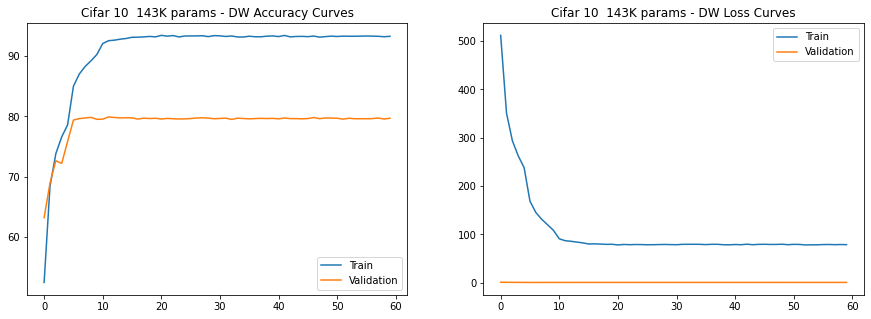

In [ ]:
plot_curves('Cifar 10  143K params - DW', model)

#### MOSAIC ML

In [ ]:
class SimpleModel(composer.models.MosaicClassifier):
    def __init__(self, num_classes: int):
        module = nn.Sequential(
    ################################## 1 ST CONVOLUTIONAL BLOCK #####################################  
            nn.Conv2d(in_channels = 3,out_channels = 16, dilation  = 1,padding = 1, kernel_size= (3,3)),                     # in 32, out 32, RF 3
            nn.ReLU(),
            nn.BatchNorm2d(16),                                                                               #26x26 /8 
            nn.Conv2d(in_channels = 16,out_channels = 16, dilation  = 1,padding = 1, kernel_size= (3,3)),                     # in 32, out 32, RF 3
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(0.06),
            nn.MaxPool2d(2, 2),


            nn.Conv2d(in_channels = 16,out_channels = 16,groups = 16, dilation  = 1,padding = 1,kernel_size= (3,3)),
            nn.Conv2d(in_channels = 16,out_channels = 32, dilation = 1,padding = 0,kernel_size= (1,1)), # 8, 8, 3  
            nn.ReLU(),
            nn.BatchNorm2d(32)  ,          
            nn.Conv2d(in_channels = 32,out_channels = 32, dilation  = 1,padding = 1, kernel_size= (3,3)),                     # in 16, out 16, RF 3
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(0.07),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(in_channels = 32,out_channels = 32,groups = 32, dilation  = 1,padding = 1,kernel_size= (3,3)),        # in 8, out 8, RF ?
            nn.Conv2d(in_channels = 32,out_channels = 64, dilation = 1,padding = 0,kernel_size= (1,1)), # 8, 8, 3           # in 8, out 8, RF ?
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels = 64,out_channels = 64, dilation  = 2,padding = 2, kernel_size= (3,3)),                     # in 8, out 8, RF 3
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(0.07),
            nn.MaxPool2d(2, 2),


            nn.Conv2d(in_channels = 64,out_channels = 64, groups = 64, dilation  = 1,padding = 1,kernel_size= (3,3)),    # in 4, out 4, RF ?
            nn.Conv2d(in_channels = 64,out_channels = 128, dilation  = 1,padding = 0,kernel_size= (1,1)),                  # in 4, out 4, RF ?
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(in_channels = 128,out_channels = 128, groups = 128, dilation  = 1,padding = 1,kernel_size= (3,3)),    # in 4, out 4,, RF ?
            nn.Conv2d(in_channels = 128,out_channels = 192, dilation  = 1,padding = 0,kernel_size= (1,1)),                  # in 4, out 4, RF ?
            nn.ReLU(),
            nn.BatchNorm2d(192),
            nn.Dropout(0.05),
            nn.Conv2d(in_channels = 192,out_channels = 192, groups = 192, dilation  = 1,padding = 1,kernel_size= (3,3)),    # in 4, out 4,, RF ?
            nn.Conv2d(in_channels = 192,out_channels = 260, dilation  = 1,padding = 0,kernel_size= (1,1)),                  # in 4, out 4, RF ?
            nn.ReLU(),
            nn.BatchNorm2d(260),

            nn.AvgPool2d(kernel_size=4),                                                                      #1x1/15
            nn.Flatten(),
            nn.Linear(260,10)
        )
        self.num_classes = num_classes
        super().__init__(module=module)

In [ ]:
t = SimpleModel(num_classes= 10)

#### Cutout  + blurpool + Mixup + SE

In [ ]:
trainer = Trainer(
    model=t,
    train_dataloader_spec=train_dataloader_spec,
    eval_dataloader_spec=eval_dataloader_spec,
    max_epochs=70,
    train_batch_size=128,
    eval_batch_size=128,
    algorithms=[
        CutOut(n_holes=1, length=10),
        BlurPool(replace_convs= True, replace_maxpools = True, blur_first = False),
        MixUp(0.5),
        SqueezeExcite(latent_channels=2, min_channels=5)
        # LabelSmoothing(alpha=0.1),
    ]
)


/usr/local/lib/python3.7/dist-packages/composer/trainer/ddp.py:137: UserWarning: NoDDPWarning: RANK and WORLD_SIZE env vars not set; assuming no parallelization. If this is unexpected, make sure you are running your training script with the composer executable.
  warnings.warn("NoDDPWarning: RANK and WORLD_SIZE env vars not set; assuming no parallelization. "
/usr/local/lib/python3.7/dist-packages/composer/utils/ddp.py:20: UserWarning: DDPDefaultValueWarning: RANK env var not set and process group not initialized; returning 0 for global rank.
  warnings.warn(f"DDPDefaultValueWarning: {env_var} env var not set"
/usr/local/lib/python3.7/dist-packages/composer/core/logging/base_backend.py:146: UserWarning: DeferredLogMetricWarning: TQDMLoggerBackend.log_metric()was invoked before training_start().This log call will be queued and processed after training_start().
  warnings.warn(f"DeferredLogMetricWarning: {self.__class__.__name__}.log_metric()"
Scheduler is stepping every epoch, but provi

In [ ]:
trainer.fit()

Streaming output truncated to the last 5000 lines.
Epoch 12: 100%|██████████| 391/391 [02:59<00:00,  2.18it/s, loss/train=1.6041]

Epoch 13: 100%|██████████| 391/391 [02:59<00:00,  2.17it/s, loss/train=0.9348]

Epoch 14: 100%|██████████| 391/391 [02:57<00:00,  2.20it/s, loss/train=1.2313]

Epoch 15: 100%|██████████| 391/391 [02:57<00:00,  2.21it/s, loss/train=1.5280]

Epoch 16: 100%|██████████| 391/391 [03:00<00:00,  2.16it/s, loss/train=0.5731]

Epoch 17: 100%|██████████| 391/391 [02:59<00:00,  2.18it/s, loss/train=0.7696]

Epoch 18: 100%|██████████| 391/391 [03:00<00:00,  2.16it/s, loss/train=0.9951]

Epoch 19: 100%|██████████| 391/391 [03:01<00:00,  2.15it/s, loss/train=1.5912]

Epoch 20: 100%|██████████| 391/391 [03:01<00:00,  2.16it/s, loss/train=1.6727]

Epoch 21: 100%|██████████| 391/391 [03:01<00:00,  2.16it/s, loss/train=0.7879]

Epoch 22: 100%|██████████| 391/391 [03:01<00:00,  2.15it/s, loss/train=1.6339]

Epoch 23: 100%|██████████| 391/391 [03:01<00:00,  2.15it/s, loss/trai

#### Cutout  + blurpool + Mixup + SAM

In [ ]:
trainer = Trainer(
    model=t,
    train_dataloader_spec=train_dataloader_spec,
    eval_dataloader_spec=eval_dataloader_spec,
    max_epochs=70,
    train_batch_size=128,
    eval_batch_size=128,
    algorithms=[
        CutOut(n_holes=1, length=10),
        BlurPool(replace_convs= True, replace_maxpools = True, blur_first = False),
        MixUp(0.5),
        SAM()
        # LabelSmoothing(alpha=0.1),
    ]
)


/usr/local/lib/python3.7/dist-packages/composer/trainer/ddp.py:137: UserWarning: NoDDPWarning: RANK and WORLD_SIZE env vars not set; assuming no parallelization. If this is unexpected, make sure you are running your training script with the composer executable.
  warnings.warn("NoDDPWarning: RANK and WORLD_SIZE env vars not set; assuming no parallelization. "
/usr/local/lib/python3.7/dist-packages/composer/utils/ddp.py:20: UserWarning: DDPDefaultValueWarning: RANK env var not set and process group not initialized; returning 0 for global rank.
  warnings.warn(f"DDPDefaultValueWarning: {env_var} env var not set"
/usr/local/lib/python3.7/dist-packages/composer/core/logging/base_backend.py:146: UserWarning: DeferredLogMetricWarning: TQDMLoggerBackend.log_metric()was invoked before training_start().This log call will be queued and processed after training_start().
  warnings.warn(f"DeferredLogMetricWarning: {self.__class__.__name__}.log_metric()"
Scheduler is stepping every epoch, but provi

In [ ]:
trainer.fit()

Streaming output truncated to the last 5000 lines.
Epoch 11 (val): 100%|██████████| 79/79 [00:12<00:00,  6.24it/s, accuracy/val=0.7843]
Epoch 12: |          | 782/? [04:50<00:00,  2.69it/s, loss/train=1.5786]

Epoch 12 (val): 100%|██████████| 79/79 [00:12<00:00,  6.21it/s, accuracy/val=0.8098]
Epoch 13: |          | 782/? [04:50<00:00,  2.69it/s, loss/train=0.6413]

Epoch 13 (val): 100%|██████████| 79/79 [00:12<00:00,  6.33it/s, accuracy/val=0.8079]
Epoch 14: |          | 782/? [04:50<00:00,  2.70it/s, loss/train=0.4882]

Epoch 14 (val): 100%|██████████| 79/79 [00:12<00:00,  6.44it/s, accuracy/val=0.8133]
Epoch 15: |          | 782/? [04:43<00:00,  2.76it/s, loss/train=1.6766]

Epoch 15 (val): 100%|██████████| 79/79 [00:12<00:00,  6.14it/s, accuracy/val=0.8077]
Epoch 16: |          | 782/? [04:46<00:00,  2.73it/s, loss/train=1.5268]

Epoch 16 (val): 100%|██████████| 79/79 [00:12<00:00,  6.32it/s, accuracy/val=0.8185]
Epoch 17: |          | 782/? [04:46<00:00,  2.73it/s, loss/train=1.63

#### Cutout  + blurpool + Mixup + Label Smoothing

In [ ]:
trainer = Trainer(
    model=t,
    train_dataloader_spec=train_dataloader_spec,
    eval_dataloader_spec=eval_dataloader_spec,
    max_epochs=70,
    train_batch_size=128,
    eval_batch_size=128,
    algorithms=[
        CutOut(n_holes=1, length=10),
        BlurPool(replace_convs= True, replace_maxpools = True, blur_first = False),
        MixUp(0.5),
        LabelSmoothing(alpha=0.1),
        # LabelSmoothing(alpha=0.1),
    ]
)


In [ ]:
trainer.fit()

#### Cutout + Blurpool +Mixup + SWA + SAM


In [ ]:
trainer = Trainer(
    model=t,
    train_dataloader_spec=train_dataloader_spec,
    eval_dataloader_spec=eval_dataloader_spec,
    max_epochs=90,
    train_batch_size=128,
    eval_batch_size=128,
    algorithms=[
        CutOut(n_holes=1, length=10),
        BlurPool(replace_convs= True, replace_maxpools = True, blur_first = False),
        MixUp(0.5),
        SAM(),
        SWA(swa_start=0.75, swa_lr=None)
        # LabelSmoothing(alpha=0.1),
    ]
)

/usr/local/lib/python3.7/dist-packages/composer/trainer/ddp.py:137: UserWarning: NoDDPWarning: RANK and WORLD_SIZE env vars not set; assuming no parallelization. If this is unexpected, make sure you are running your training script with the composer executable.
  warnings.warn("NoDDPWarning: RANK and WORLD_SIZE env vars not set; assuming no parallelization. "
/usr/local/lib/python3.7/dist-packages/composer/utils/ddp.py:20: UserWarning: DDPDefaultValueWarning: RANK env var not set and process group not initialized; returning 0 for global rank.
  warnings.warn(f"DDPDefaultValueWarning: {env_var} env var not set"
/usr/local/lib/python3.7/dist-packages/composer/core/logging/base_backend.py:146: UserWarning: DeferredLogMetricWarning: TQDMLoggerBackend.log_metric()was invoked before training_start().This log call will be queued and processed after training_start().
  warnings.warn(f"DeferredLogMetricWarning: {self.__class__.__name__}.log_metric()"
Scheduler is stepping every epoch, but provi

In [ ]:
trainer.fit()

/usr/local/lib/python3.7/dist-packages/composer/utils/ddp.py:20: UserWarning: DDPDefaultValueWarning: WORLD_SIZE env var not set and process group not initialized; returning 1 for world size.
  warnings.warn(f"DDPDefaultValueWarning: {env_var} env var not set"
/usr/local/lib/python3.7/dist-packages/composer/utils/ddp.py:20: UserWarning: DDPDefaultValueWarning: RANK env var not set and process group not initialized; returning 0 for global rank.
  warnings.warn(f"DDPDefaultValueWarning: {env_var} env var not set"
/usr/local/lib/python3.7/dist-packages/composer/core/logging/base_backend.py:146: UserWarning: DeferredLogMetricWarning: TQDMLoggerBackend.log_metric()was invoked before training_start().This log call will be queued and processed after training_start().
  warnings.warn(f"DeferredLogMetricWarning: {self.__class__.__name__}.log_metric()"
/usr/local/lib/python3.7/dist-packages/composer/utils/ddp.py:20: UserWarning: DDPDefaultValueWarning: RANK env var not set and process group not 

 ## Cutout + Blurpool +Mixup + SWA + SAM + LS

In [ ]:
trainer = Trainer(
    model=t,
    train_dataloader_spec=train_dataloader_spec,
    eval_dataloader_spec=eval_dataloader_spec,
    max_epochs=120,
    train_batch_size=128,
    eval_batch_size=128,
    algorithms=[
        CutOut(n_holes=1, length=10),
        BlurPool(replace_convs= True, replace_maxpools = True, blur_first = False),
        MixUp(0.5),
        SAM(),
        SWA(swa_start=0.75, swa_lr=None),
        LabelSmoothing(alpha=0.1),
    ]
)

/usr/local/lib/python3.7/dist-packages/composer/trainer/ddp.py:137: UserWarning: NoDDPWarning: RANK and WORLD_SIZE env vars not set; assuming no parallelization. If this is unexpected, make sure you are running your training script with the composer executable.
  warnings.warn("NoDDPWarning: RANK and WORLD_SIZE env vars not set; assuming no parallelization. "
/usr/local/lib/python3.7/dist-packages/composer/utils/ddp.py:20: UserWarning: DDPDefaultValueWarning: RANK env var not set and process group not initialized; returning 0 for global rank.
  warnings.warn(f"DDPDefaultValueWarning: {env_var} env var not set"
/usr/local/lib/python3.7/dist-packages/composer/core/logging/base_backend.py:146: UserWarning: DeferredLogMetricWarning: TQDMLoggerBackend.log_metric()was invoked before training_start().This log call will be queued and processed after training_start().
  warnings.warn(f"DeferredLogMetricWarning: {self.__class__.__name__}.log_metric()"
Scheduler is stepping every epoch, but provi

In [ ]:
trainer.fit()

Streaming output truncated to the last 5000 lines.
Epoch 61 (val): 100%|██████████| 79/79 [00:08<00:00,  8.92it/s, accuracy/val=0.8544]
Epoch 62: |          | 782/? [03:13<00:00,  4.04it/s, loss/train=0.7987]

Epoch 62 (val): 100%|██████████| 79/79 [00:08<00:00,  9.17it/s, accuracy/val=0.8490]
Epoch 63: |          | 782/? [03:14<00:00,  4.03it/s, loss/train=0.8097]

Epoch 63 (val): 100%|██████████| 79/79 [00:08<00:00,  9.04it/s, accuracy/val=0.8489]
Epoch 64: |          | 782/? [03:14<00:00,  4.02it/s, loss/train=1.2142]

Epoch 64 (val): 100%|██████████| 79/79 [00:08<00:00,  8.92it/s, accuracy/val=0.8609]
Epoch 65: |          | 782/? [03:14<00:00,  4.02it/s, loss/train=1.1755]

Epoch 65 (val): 100%|██████████| 79/79 [00:08<00:00,  9.01it/s, accuracy/val=0.8603]
Epoch 66: |          | 782/? [03:14<00:00,  4.02it/s, loss/train=1.0781]

Epoch 66 (val): 100%|██████████| 79/79 [00:08<00:00,  9.01it/s, accuracy/val=0.8543]
Epoch 67: |          | 782/? [03:15<00:00,  4.00it/s, loss/train=1.12

#### Cutout  + blurpool + Mixup

In [ ]:
trainer = Trainer(
    model=t,
    train_dataloader_spec=train_dataloader_spec,
    eval_dataloader_spec=eval_dataloader_spec,
    max_epochs=70,
    train_batch_size=128,
    eval_batch_size=128,
    algorithms=[
        CutOut(n_holes=1, length=10),
        BlurPool(replace_convs= True, replace_maxpools = True, blur_first = False),
        MixUp(0.5)
        # LabelSmoothing(alpha=0.1),
    ]
)


/usr/local/lib/python3.7/dist-packages/composer/trainer/ddp.py:137: UserWarning: NoDDPWarning: RANK and WORLD_SIZE env vars not set; assuming no parallelization. If this is unexpected, make sure you are running your training script with the composer executable.
  warnings.warn("NoDDPWarning: RANK and WORLD_SIZE env vars not set; assuming no parallelization. "
/usr/local/lib/python3.7/dist-packages/composer/utils/ddp.py:20: UserWarning: DDPDefaultValueWarning: RANK env var not set and process group not initialized; returning 0 for global rank.
  warnings.warn(f"DDPDefaultValueWarning: {env_var} env var not set"
/usr/local/lib/python3.7/dist-packages/composer/core/logging/base_backend.py:146: UserWarning: DeferredLogMetricWarning: TQDMLoggerBackend.log_metric()was invoked before training_start().This log call will be queued and processed after training_start().
  warnings.warn(f"DeferredLogMetricWarning: {self.__class__.__name__}.log_metric()"
Scheduler is stepping every epoch, but provi

In [ ]:
trainer.fit()

Streaming output truncated to the last 5000 lines.
Epoch 12: 100%|██████████| 391/391 [02:42<00:00,  2.41it/s, loss/train=0.5327]

Epoch 13: 100%|██████████| 391/391 [02:43<00:00,  2.40it/s, loss/train=0.8381]

Epoch 14: 100%|██████████| 391/391 [02:43<00:00,  2.40it/s, loss/train=0.7831]

Epoch 15: 100%|██████████| 391/391 [02:42<00:00,  2.40it/s, loss/train=0.9392]

Epoch 16: 100%|██████████| 391/391 [02:42<00:00,  2.40it/s, loss/train=1.7483]

Epoch 17: 100%|██████████| 391/391 [02:43<00:00,  2.39it/s, loss/train=0.7279]

Epoch 18: 100%|██████████| 391/391 [02:43<00:00,  2.40it/s, loss/train=1.2234]

Epoch 19: 100%|██████████| 391/391 [02:43<00:00,  2.38it/s, loss/train=1.6214]

Epoch 20: 100%|██████████| 391/391 [02:44<00:00,  2.38it/s, loss/train=1.4489]

Epoch 21: 100%|██████████| 391/391 [02:44<00:00,  2.37it/s, loss/train=1.1166]

Epoch 22: 100%|██████████| 391/391 [02:44<00:00,  2.38it/s, loss/train=1.2631]

Epoch 23: 100%|██████████| 391/391 [02:44<00:00,  2.37it/s, loss/trai

#### Cutout

In [ ]:
trainer = Trainer(
    model=m,
    train_dataloader_spec=train_dataloader_spec,
    eval_dataloader_spec=eval_dataloader_spec,
    max_epochs=70,
    train_batch_size=128,
    eval_batch_size=128,
    algorithms=[
        CutOut(n_holes=1, length=10),
        # LabelSmoothing(alpha=0.1),
    ]
)


/usr/local/lib/python3.7/dist-packages/composer/trainer/ddp.py:137: UserWarning: NoDDPWarning: RANK and WORLD_SIZE env vars not set; assuming no parallelization. If this is unexpected, make sure you are running your training script with the composer executable.
  warnings.warn("NoDDPWarning: RANK and WORLD_SIZE env vars not set; assuming no parallelization. "
/usr/local/lib/python3.7/dist-packages/composer/utils/ddp.py:20: UserWarning: DDPDefaultValueWarning: RANK env var not set and process group not initialized; returning 0 for global rank.
  warnings.warn(f"DDPDefaultValueWarning: {env_var} env var not set"
Scheduler is stepping every epoch, but provided timestring 5ba had batches. Ignoring the batches term.


In [ ]:
trainer.fit()

Streaming output truncated to the last 5000 lines.
Epoch 12: 100%|██████████| 391/391 [02:17<00:00,  2.84it/s, loss/train=0.5301]

Epoch 13: 100%|██████████| 391/391 [02:18<00:00,  2.82it/s, loss/train=0.5605]

Epoch 14: 100%|██████████| 391/391 [02:19<00:00,  2.81it/s, loss/train=0.4537]

Epoch 15: 100%|██████████| 391/391 [02:19<00:00,  2.81it/s, loss/train=0.5987]

Epoch 16: 100%|██████████| 391/391 [02:18<00:00,  2.82it/s, loss/train=0.7454]

Epoch 17: 100%|██████████| 391/391 [02:19<00:00,  2.81it/s, loss/train=0.5977]

Epoch 18: 100%|██████████| 391/391 [02:19<00:00,  2.80it/s, loss/train=0.4773]

Epoch 19: 100%|██████████| 391/391 [02:21<00:00,  2.76it/s, loss/train=0.3095]

Epoch 20: 100%|██████████| 391/391 [02:20<00:00,  2.78it/s, loss/train=0.2885]

Epoch 21: 100%|██████████| 391/391 [02:20<00:00,  2.79it/s, loss/train=0.4759]

Epoch 22: 100%|██████████| 391/391 [02:20<00:00,  2.78it/s, loss/train=0.3603]

Epoch 23: 100%|██████████| 391/391 [02:22<00:00,  2.74it/s, loss/trai

#### label Smoothing

In [ ]:
trainer = Trainer(
    model=m,
    train_dataloader_spec=train_dataloader_spec,
    eval_dataloader_spec=eval_dataloader_spec,
    max_epochs=70,
    train_batch_size=128,
    eval_batch_size=128,
    checkpoint_interval_unit="ep",
    checkpoint_folder="label_smoothing_checkpoints_cifar10",
    checkpoint_interval=1,
    # device =  'DeviceGPU',
    # device ='cuda',
    algorithms=[
        # CutOut(n_holes=1, length=10),
        LabelSmoothing(alpha=0.1),
        # BlurPool(replace_convs= True, replace_maxpools = True, blur_first = False)
    ],
)


/usr/local/lib/python3.7/dist-packages/composer/trainer/ddp.py:137: UserWarning: NoDDPWarning: RANK and WORLD_SIZE env vars not set; assuming no parallelization. If this is unexpected, make sure you are running your training script with the composer executable.
  warnings.warn("NoDDPWarning: RANK and WORLD_SIZE env vars not set; assuming no parallelization. "
/usr/local/lib/python3.7/dist-packages/composer/utils/ddp.py:20: UserWarning: DDPDefaultValueWarning: RANK env var not set and process group not initialized; returning 0 for global rank.
  warnings.warn(f"DDPDefaultValueWarning: {env_var} env var not set"
Scheduler is stepping every epoch, but provided timestring 5ba had batches. Ignoring the batches term.


In [ ]:
trainer.fit()

/usr/local/lib/python3.7/dist-packages/composer/utils/ddp.py:20: UserWarning: DDPDefaultValueWarning: WORLD_SIZE env var not set and process group not initialized; returning 1 for world size.
  warnings.warn(f"DDPDefaultValueWarning: {env_var} env var not set"
/usr/local/lib/python3.7/dist-packages/composer/utils/ddp.py:20: UserWarning: DDPDefaultValueWarning: RANK env var not set and process group not initialized; returning 0 for global rank.
  warnings.warn(f"DDPDefaultValueWarning: {env_var} env var not set"
/usr/local/lib/python3.7/dist-packages/composer/core/logging/base_backend.py:146: UserWarning: DeferredLogMetricWarning: TQDMLoggerBackend.log_metric()was invoked before training_start().This log call will be queued and processed after training_start().
  warnings.warn(f"DeferredLogMetricWarning: {self.__class__.__name__}.log_metric()"
/usr/local/lib/python3.7/dist-packages/composer/utils/ddp.py:20: UserWarning: DDPDefaultValueWarning: RANK env var not set and process group not 

#### Blurpool

In [ ]:
trainer = Trainer(
    model=m,
    train_dataloader_spec=train_dataloader_spec,
    eval_dataloader_spec=eval_dataloader_spec,
    max_epochs=70,
    train_batch_size=128,
    eval_batch_size=128,
    algorithms=[
        # CutOut(n_holes=1, length=10),
        # LabelSmoothing(alpha=0.1),
        BlurPool(replace_convs= True, replace_maxpools = True, blur_first = False)
    ]
)


/usr/local/lib/python3.7/dist-packages/composer/trainer/ddp.py:137: UserWarning: NoDDPWarning: RANK and WORLD_SIZE env vars not set; assuming no parallelization. If this is unexpected, make sure you are running your training script with the composer executable.
  warnings.warn("NoDDPWarning: RANK and WORLD_SIZE env vars not set; assuming no parallelization. "
/usr/local/lib/python3.7/dist-packages/composer/utils/ddp.py:20: UserWarning: DDPDefaultValueWarning: RANK env var not set and process group not initialized; returning 0 for global rank.
  warnings.warn(f"DDPDefaultValueWarning: {env_var} env var not set"
/usr/local/lib/python3.7/dist-packages/composer/core/logging/base_backend.py:146: UserWarning: DeferredLogMetricWarning: TQDMLoggerBackend.log_metric()was invoked before training_start().This log call will be queued and processed after training_start().
  warnings.warn(f"DeferredLogMetricWarning: {self.__class__.__name__}.log_metric()"
Scheduler is stepping every epoch, but provi

In [ ]:
trainer.fit()

Streaming output truncated to the last 5000 lines.
Epoch 12: 100%|██████████| 391/391 [02:33<00:00,  2.55it/s, loss/train=0.3138]

Epoch 13: 100%|██████████| 391/391 [02:29<00:00,  2.62it/s, loss/train=0.3676]

Epoch 14: 100%|██████████| 391/391 [02:32<00:00,  2.57it/s, loss/train=0.2022]

Epoch 15: 100%|██████████| 391/391 [02:31<00:00,  2.58it/s, loss/train=0.3441]

Epoch 16: 100%|██████████| 391/391 [02:31<00:00,  2.58it/s, loss/train=0.4548]

Epoch 17: 100%|██████████| 391/391 [02:35<00:00,  2.51it/s, loss/train=0.1456]

Epoch 18: 100%|██████████| 391/391 [02:33<00:00,  2.55it/s, loss/train=0.3216]

Epoch 19: 100%|██████████| 391/391 [02:36<00:00,  2.51it/s, loss/train=0.3007]

Epoch 20: 100%|██████████| 391/391 [02:37<00:00,  2.48it/s, loss/train=0.1364]

Epoch 21: 100%|██████████| 391/391 [02:37<00:00,  2.48it/s, loss/train=0.1680]

Epoch 22: 100%|██████████| 391/391 [02:37<00:00,  2.49it/s, loss/train=0.1107]

Epoch 23: 100%|██████████| 391/391 [02:38<00:00,  2.46it/s, loss/trai

#### SWA

In [ ]:
trainer = Trainer(
    model=m,
    train_dataloader_spec=train_dataloader_spec,
    eval_dataloader_spec=eval_dataloader_spec,
    max_epochs=70,
    train_batch_size=128,
    eval_batch_size=128,
    checkpoint_interval_unit="ep",
    checkpoint_folder="swa_checkpoints_cifar10",
    checkpoint_interval=1,
    # device =  'DeviceGPU',
    # device ='cuda',
    algorithms=[
        SWA(swa_start=0.75, swa_lr=None)
    ],
)

/usr/local/lib/python3.7/dist-packages/composer/trainer/ddp.py:137: UserWarning: NoDDPWarning: RANK and WORLD_SIZE env vars not set; assuming no parallelization. If this is unexpected, make sure you are running your training script with the composer executable.
  warnings.warn("NoDDPWarning: RANK and WORLD_SIZE env vars not set; assuming no parallelization. "
/usr/local/lib/python3.7/dist-packages/composer/utils/ddp.py:20: UserWarning: DDPDefaultValueWarning: RANK env var not set and process group not initialized; returning 0 for global rank.
  warnings.warn(f"DDPDefaultValueWarning: {env_var} env var not set"
Scheduler is stepping every epoch, but provided timestring 5ba had batches. Ignoring the batches term.


In [ ]:
trainer.fit()

Streaming output truncated to the last 5000 lines.
Epoch 5: 100%|██████████| 391/391 [02:02<00:00,  3.20it/s, loss/train=0.6261]

Epoch 6: 100%|██████████| 391/391 [02:03<00:00,  3.17it/s, loss/train=0.5206]

Epoch 7: 100%|██████████| 391/391 [02:00<00:00,  3.24it/s, loss/train=0.5588]

Epoch 8: 100%|██████████| 391/391 [02:05<00:00,  3.13it/s, loss/train=0.4718]

Epoch 9: 100%|██████████| 391/391 [02:02<00:00,  3.19it/s, loss/train=0.5794]

Epoch 10: 100%|██████████| 391/391 [02:02<00:00,  3.18it/s, loss/train=0.4120]

Epoch 11: 100%|██████████| 391/391 [02:03<00:00,  3.16it/s, loss/train=0.3459]

Epoch 12: 100%|██████████| 391/391 [02:04<00:00,  3.14it/s, loss/train=0.3378]

Epoch 13: 100%|██████████| 391/391 [02:05<00:00,  3.12it/s, loss/train=0.4789]

Epoch 14: 100%|██████████| 391/391 [02:06<00:00,  3.09it/s, loss/train=0.2720]

Epoch 15: 100%|██████████| 391/391 [02:05<00:00,  3.12it/s, loss/train=0.3778]

Epoch 16: 100%|██████████| 391/391 [02:06<00:00,  3.10it/s, loss/train=0.3

#### Mixup

In [ ]:
trainer = Trainer(
    model=m,
    train_dataloader_spec=train_dataloader_spec,
    eval_dataloader_spec=eval_dataloader_spec,
    max_epochs=70,
    train_batch_size=128,
    eval_batch_size=128,
    checkpoint_interval=1,
    # device =  'DeviceGPU',
    # device ='cuda',
    algorithms=[
        MixUp(0.5)
    ],
)


/usr/local/lib/python3.7/dist-packages/composer/utils/ddp.py:20: UserWarning: DDPDefaultValueWarning: RANK env var not set and process group not initialized; returning 0 for global rank.
  warnings.warn(f"DDPDefaultValueWarning: {env_var} env var not set"


In [ ]:
trainer.fit()

Streaming output truncated to the last 5000 lines.
Epoch 7: 100%|██████████| 391/391 [02:10<00:00,  3.00it/s, loss/train=1.7639]

Epoch 8: 100%|██████████| 391/391 [02:08<00:00,  3.05it/s, loss/train=1.3959]

Epoch 9: 100%|██████████| 391/391 [02:10<00:00,  3.01it/s, loss/train=1.0378]

Epoch 10: 100%|██████████| 391/391 [02:09<00:00,  3.02it/s, loss/train=0.4823]

Epoch 11: 100%|██████████| 391/391 [02:10<00:00,  2.99it/s, loss/train=0.7445]

Epoch 12: 100%|██████████| 391/391 [02:10<00:00,  2.99it/s, loss/train=1.6270]

Epoch 13: 100%|██████████| 391/391 [02:11<00:00,  2.98it/s, loss/train=0.6676]

Epoch 14: 100%|██████████| 391/391 [02:11<00:00,  2.98it/s, loss/train=1.4343]

Epoch 15: 100%|██████████| 391/391 [02:09<00:00,  3.03it/s, loss/train=0.6577]

Epoch 16: 100%|██████████| 391/391 [02:14<00:00,  2.92it/s, loss/train=0.8070]

Epoch 17: 100%|██████████| 391/391 [02:13<00:00,  2.92it/s, loss/train=1.1337]

Epoch 18: 100%|██████████| 391/391 [02:11<00:00,  2.96it/s, loss/train=1

#### Sharpness Awareness Minimization

In [ ]:
trainer = Trainer(
    model=m,
    train_dataloader_spec=train_dataloader_spec,
    eval_dataloader_spec=eval_dataloader_spec,
    max_epochs=70,
    train_batch_size=128,
    eval_batch_size=128,
    checkpoint_interval=1,
    # device =  'DeviceGPU',
    # device ='cuda',
    algorithms=[
        SAM()
    ],
)


/usr/local/lib/python3.7/dist-packages/composer/trainer/ddp.py:137: UserWarning: NoDDPWarning: RANK and WORLD_SIZE env vars not set; assuming no parallelization. If this is unexpected, make sure you are running your training script with the composer executable.
  warnings.warn("NoDDPWarning: RANK and WORLD_SIZE env vars not set; assuming no parallelization. "
/usr/local/lib/python3.7/dist-packages/composer/utils/ddp.py:20: UserWarning: DDPDefaultValueWarning: RANK env var not set and process group not initialized; returning 0 for global rank.
  warnings.warn(f"DDPDefaultValueWarning: {env_var} env var not set"
Scheduler is stepping every epoch, but provided timestring 5ba had batches. Ignoring the batches term.


In [ ]:
trainer.fit()

/usr/local/lib/python3.7/dist-packages/composer/utils/ddp.py:20: UserWarning: DDPDefaultValueWarning: WORLD_SIZE env var not set and process group not initialized; returning 1 for world size.
  warnings.warn(f"DDPDefaultValueWarning: {env_var} env var not set"
/usr/local/lib/python3.7/dist-packages/composer/utils/ddp.py:20: UserWarning: DDPDefaultValueWarning: RANK env var not set and process group not initialized; returning 0 for global rank.
  warnings.warn(f"DDPDefaultValueWarning: {env_var} env var not set"
/usr/local/lib/python3.7/dist-packages/composer/core/logging/base_backend.py:146: UserWarning: DeferredLogMetricWarning: TQDMLoggerBackend.log_metric()was invoked before training_start().This log call will be queued and processed after training_start().
  warnings.warn(f"DeferredLogMetricWarning: {self.__class__.__name__}.log_metric()"
/usr/local/lib/python3.7/dist-packages/composer/utils/ddp.py:20: UserWarning: DDPDefaultValueWarning: RANK env var not set and process group not 

#### SQUEEZE AND EXCITTE

In [ ]:
trainer = Trainer(
    model=t,
    train_dataloader_spec=train_dataloader_spec,
    eval_dataloader_spec=eval_dataloader_spec,
    max_epochs=70,
    train_batch_size=128,
    eval_batch_size=128,
    checkpoint_interval=1,
    # device =  'DeviceGPU',
    # device ='cuda',
    algorithms=[
        SqueezeExcite(latent_channels=2, min_channels=5)
    ],
)

/usr/local/lib/python3.7/dist-packages/composer/trainer/ddp.py:137: UserWarning: NoDDPWarning: RANK and WORLD_SIZE env vars not set; assuming no parallelization. If this is unexpected, make sure you are running your training script with the composer executable.
  warnings.warn("NoDDPWarning: RANK and WORLD_SIZE env vars not set; assuming no parallelization. "
/usr/local/lib/python3.7/dist-packages/composer/utils/ddp.py:20: UserWarning: DDPDefaultValueWarning: RANK env var not set and process group not initialized; returning 0 for global rank.
  warnings.warn(f"DDPDefaultValueWarning: {env_var} env var not set"
/usr/local/lib/python3.7/dist-packages/composer/core/logging/base_backend.py:146: UserWarning: DeferredLogMetricWarning: TQDMLoggerBackend.log_metric()was invoked before training_start().This log call will be queued and processed after training_start().
  warnings.warn(f"DeferredLogMetricWarning: {self.__class__.__name__}.log_metric()"
Scheduler is stepping every epoch, but provi

In [ ]:
trainer.fit()

/usr/local/lib/python3.7/dist-packages/composer/utils/ddp.py:20: UserWarning: DDPDefaultValueWarning: WORLD_SIZE env var not set and process group not initialized; returning 1 for world size.
  warnings.warn(f"DDPDefaultValueWarning: {env_var} env var not set"
/usr/local/lib/python3.7/dist-packages/composer/utils/ddp.py:20: UserWarning: DDPDefaultValueWarning: RANK env var not set and process group not initialized; returning 0 for global rank.
  warnings.warn(f"DDPDefaultValueWarning: {env_var} env var not set"
/usr/local/lib/python3.7/dist-packages/composer/core/logging/base_backend.py:146: UserWarning: DeferredLogMetricWarning: TQDMLoggerBackend.log_metric()was invoked before training_start().This log call will be queued and processed after training_start().
  warnings.warn(f"DeferredLogMetricWarning: {self.__class__.__name__}.log_metric()"
/usr/local/lib/python3.7/dist-packages/composer/utils/ddp.py:20: UserWarning: DDPDefaultValueWarning: RANK env var not set and process group not 

#### SMALLER MODEL - 5K

In [ ]:
class CNet(nn.Module):
    def __init__(self):
        super(CNet, self).__init__()
    #####################################################################################################
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False), 
            nn.ReLU(),
            nn.BatchNorm2d(8),
        ) # input size = 28 output_size = 26, in channels  = 1 out channels = 16

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(12),            
        ) # input_size = 26 , output_size = 24, 16 to 32 channels

        self.dropout1  = nn.Sequential(nn.Dropout(0.05))
    #####################################################################################################

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),
        ) # input size  = 24, output_size = 24
        self.pool1 = nn.MaxPool2d(2, 2) # input sizez = 24, output_size = 12
    #####################################################################################################

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(12),
            # nn.Dropout(dropout_value)
        ) # input size = 12, output_size = 10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            # nn.Dropout(dropout_value)
        ) # input size = 10, output_size = 8
        self.dropout2  = nn.Sequential(nn.Dropout(0.17))
    #####################################################################################################

        # adding a 1x1 kernel  block here to reduce paramters
        self.convblock5a = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=12, kernel_size=(1, 1), padding=0, bias=False),
        ) # input size  = 8, output_size = 8
        self.pool2 = nn.MaxPool2d(2, 2) # input sizez = 8, output_size = 4
    #####################################################################################################

        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=15, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(15),
            # nn.Dropout(dropout_value)
        ) # input size  = 4,  output_size = 4
        self.dropout3  = nn.Sequential(nn.Dropout(0.17))
        # self.convblock7 = nn.Sequential(
        #     nn.Conv2d(in_channels=15, out_channels=15, kernel_size=(3, 3), padding=1, bias=False),
        #     nn.ReLU(),            
        #     nn.BatchNorm2d(15),
        #     # nn.Dropout(0.03)
        # ) # input size  = 4, output_size = 4
    #####################################################################################################        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=4)
        ) # output_size = 1 channels  = 16

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=15, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) 

    def forward(self, x):
        # first conv block-assistant
        # x = x.to("cuda")
        x = self.convblock1(x)
        x = self.convblock2(x)
        x  = self.dropout1(x)

        # transition block
        x = self.convblock3(x)
        x = self.pool1(x)

        # second conv block
        x = self.convblock4(x)
        x = self.convblock5(x)
        x  = self.dropout2(x)

        # secocnd transition block
        x = self.convblock5a(x)
        x = self.pool2(x)        

        # third conv block
        x = self.convblock6(x)
        x = self.dropout3(x)
        # x = self.convblock7(x)

        # global average pooling layer
        x = self.gap(x) 

        # classification        
        x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

#### SMALLEST MODEL

In [ ]:
class SNet(nn.Module):
    def __init__(self):
        super(SNet, self).__init__()
    #####################################################################################################
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False), 
            nn.ReLU(),
            nn.BatchNorm2d(8),
        ) # input size = 28 output_size = 26, in channels  = 1 out channels = 16

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            # DEPTH WISE SEPERABLE COVOLUTION
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3, 3), groups = 8, padding=0, bias=False),
            nn.Conv2d(in_channels=8, out_channels=12, kernel_size=(1, 1), groups = 1, padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(12),            
        ) # input_size = 26 , output_size = 24, 16 to 32 channels

        self.dropout1  = nn.Sequential(nn.Dropout(0.05))
    #####################################################################################################

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),
        ) # input size  = 24, output_size = 24
        self.pool1 = nn.MaxPool2d(2, 2) # input sizez = 24, output_size = 12
    #####################################################################################################

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            # DEPTH WISE SEPARABLE CONVOLUTIONS
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3, 3), groups = 8, padding=0, bias=False),
            nn.Conv2d(in_channels=8, out_channels=12, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(12),
            # nn.Dropout(dropout_value)
        ) # input size = 12, output_size = 10
        self.convblock5 = nn.Sequential(
            # DEPTH WISE SEPARABLE CONVOLUTIONS
            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(3, 3),groups = 12, padding=0, bias=False),
            nn.Conv2d(in_channels=12, out_channels=16, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            # nn.Dropout(dropout_value)
        ) # input size = 10, output_size = 8
        self.dropout2  = nn.Sequential(nn.Dropout(0.17))
    #####################################################################################################

        # adding a 1x1 kernel  block here to reduce paramters
        self.convblock5a = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=12, kernel_size=(1, 1), padding=0, bias=False),
        ) # input size  = 8, output_size = 8
        self.pool2 = nn.MaxPool2d(2, 2) # input sizez = 8, output_size = 4
    #####################################################################################################

        self.convblock6 = nn.Sequential(
            # DEPTH WISE SEPARABLE CONVOLUTIONS
            nn.Conv2d(in_channels=12, out_channels=12,groups = 12, kernel_size=(3, 3), padding=1, bias=False),
            nn.Conv2d(in_channels=12, out_channels=15, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(15),
            # nn.Dropout(dropout_value)
        ) # input size  = 4,  output_size = 4
        self.dropout3  = nn.Sequential(nn.Dropout(0.17))
    #####################################################################################################        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=4)
        ) # output_size = 1 channels  = 16
        self.flat = nn.Flatten()
        # self.convblock8 = nn.Sequential(
            # nn.Conv2d(in_channels=15, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        # ) 
        self.linear = nn.Linear(15,10)

    def forward(self, x):
        # first conv block - student
        # x = x.to("cuda")
        x = self.convblock1(x)
        x = self.convblock2(x)
        x  = self.dropout1(x)

        # transition block
        x = self.convblock3(x)
        x = self.pool1(x)

        # second conv block
        x = self.convblock4(x)
        x = self.convblock5(x)
        x  = self.dropout2(x)

        # secocnd transition block
        x = self.convblock5a(x)
        x = self.pool2(x)        

        # third conv block
        x = self.convblock6(x)
        x = self.dropout3(x)
        # x = self.convblock7(x)

        # global average pooling layer
        x = self.gap(x) 
        x = self.flat(x)
        # classification        
        # x = self.convblock8(x)
        x = self.linear(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

#### SMALLEST MODEL 2

In [ ]:
class SimpleModel(composer.models.MosaicClassifier):
    def __init__(self, num_classes: int):
        module = nn.Sequential(
    ################################## 1 ST CONVOLUTIONAL BLOCK #####################################  
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False), 
            nn.ReLU(),
            nn.BatchNorm2d(8),                                                                                #26x26 /8 

            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3, 3), groups = 8, padding=0, bias=False),  #24x24/8
            nn.Conv2d(in_channels=8, out_channels=12, kernel_size=(1, 1), groups = 1, padding=0, bias=False), #24x24/12
            nn.ReLU(),
            nn.BatchNorm2d(12), 

            nn.Dropout(0.05),
    ################################### TRANSITION BLOCK #######################################
            nn.Conv2d(in_channels=12, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),             #24x24/8
            nn.MaxPool2d(2, 2),                                                                               #12x12/8
    ################################## 2 ND CONVOLUTIONAL BLOCK #####################################            

            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3, 3), groups = 8, padding=0, bias=False),  #10x10/8
            nn.Conv2d(in_channels=8, out_channels=12, kernel_size=(1, 1), padding=0, bias=False),             #10x10/12
            nn.ReLU(),            
            nn.BatchNorm2d(12),

            # DEPTH WISE SEPARABLE CONVOLUTIONS
            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(3, 3),groups = 12, padding=0, bias=False), #8x8/12
            nn.Conv2d(in_channels=12, out_channels=16, kernel_size=(1, 1), padding=0, bias=False),             #8x8/16
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            
            nn.Dropout(0.17),
    ################################### TRANSITION BLOCK #######################################
            nn.Conv2d(in_channels=16, out_channels=12, kernel_size=(1, 1), padding=0, bias=False),            #8x8/12
            nn.MaxPool2d(2, 2),                                                                               #4x4/12
    ################################## 3 RD CONVOLUTIONAL BLOCK ##################################### 
            nn.Conv2d(in_channels=12, out_channels=12,groups = 12, kernel_size=(3, 3), padding=1, bias=False),#4x4/12
            nn.Conv2d(in_channels=12, out_channels=15, kernel_size=(1, 1), padding=0, bias=False),            #4x4/15
            nn.ReLU(),            
            nn.BatchNorm2d(15),
            
            nn.Dropout(0.17),
    ################################### OUTPUT BLOCK ######################################        
            nn.AvgPool2d(kernel_size=4),                                                                      #1x1/15
            # nn.Linear(1,10),
            nn.Flatten(),
            # nn.Conv2d(in_channels=15, out_channels=num_classes, kernel_size=(1, 1), padding=0, bias=False),
            nn.Linear(15,10)
        )
        self.num_classes = num_classes
        super().__init__(module=module)

In [ ]:
m = SimpleModel(num_classes= 10)

In [ ]:
train_dataloader_spec = DataloaderSpec(
    dataset=datasets.CIFAR10('/datasets10/', train=True, transform=transforms.ToTensor(), download=True),
    drop_last=False,
    shuffle=True,
)

eval_dataloader_spec = DataloaderSpec(
    dataset=datasets.CIFAR10('/datasets10/', train=False, transform=transforms.ToTensor()),
    drop_last=False,
    shuffle=False,
)

#### CUTOUT

In [ ]:
trainer = Trainer(
    model=m,
    train_dataloader_spec=train_dataloader_spec,
    eval_dataloader_spec=eval_dataloader_spec,
    max_epochs=70,
    train_batch_size=128,
    eval_batch_size=128,
    algorithms=[
        CutOut(n_holes=1, length=10),
        # LabelSmoothing(alpha=0.1),
    ]
)


/usr/local/lib/python3.7/dist-packages/composer/trainer/ddp.py:137: UserWarning: NoDDPWarning: RANK and WORLD_SIZE env vars not set; assuming no parallelization. If this is unexpected, make sure you are running your training script with the composer executable.
  warnings.warn("NoDDPWarning: RANK and WORLD_SIZE env vars not set; assuming no parallelization. "
/usr/local/lib/python3.7/dist-packages/composer/utils/ddp.py:20: UserWarning: DDPDefaultValueWarning: RANK env var not set and process group not initialized; returning 0 for global rank.
  warnings.warn(f"DDPDefaultValueWarning: {env_var} env var not set"
Scheduler is stepping every epoch, but provided timestring 5ba had batches. Ignoring the batches term.


In [ ]:
trainer.fit()

/usr/local/lib/python3.7/dist-packages/composer/utils/ddp.py:20: UserWarning: DDPDefaultValueWarning: WORLD_SIZE env var not set and process group not initialized; returning 1 for world size.
  warnings.warn(f"DDPDefaultValueWarning: {env_var} env var not set"
/usr/local/lib/python3.7/dist-packages/composer/utils/ddp.py:20: UserWarning: DDPDefaultValueWarning: RANK env var not set and process group not initialized; returning 0 for global rank.
  warnings.warn(f"DDPDefaultValueWarning: {env_var} env var not set"
/usr/local/lib/python3.7/dist-packages/composer/core/logging/base_backend.py:146: UserWarning: DeferredLogMetricWarning: TQDMLoggerBackend.log_metric()was invoked before training_start().This log call will be queued and processed after training_start().
  warnings.warn(f"DeferredLogMetricWarning: {self.__class__.__name__}.log_metric()"
/usr/local/lib/python3.7/dist-packages/composer/utils/ddp.py:20: UserWarning: DDPDefaultValueWarning: RANK env var not set and process group not 

#### BLURPOOL

In [ ]:
trainer = Trainer(
    model=m,
    train_dataloader_spec=train_dataloader_spec,
    eval_dataloader_spec=eval_dataloader_spec,
    max_epochs=70,
    train_batch_size=128,
    eval_batch_size=128,
    algorithms=[
        # CutOut(n_holes=1, length=10),
        # LabelSmoothing(alpha=0.1),
        BlurPool(replace_convs= True, replace_maxpools = True, blur_first = False)
    ]
)


/usr/local/lib/python3.7/dist-packages/composer/utils/ddp.py:20: UserWarning: DDPDefaultValueWarning: RANK env var not set and process group not initialized; returning 0 for global rank.
  warnings.warn(f"DDPDefaultValueWarning: {env_var} env var not set"
/usr/local/lib/python3.7/dist-packages/composer/core/logging/base_backend.py:146: UserWarning: DeferredLogMetricWarning: TQDMLoggerBackend.log_metric()was invoked before training_start().This log call will be queued and processed after training_start().
  warnings.warn(f"DeferredLogMetricWarning: {self.__class__.__name__}.log_metric()"
Scheduler is stepping every epoch, but provided timestring 5ba had batches. Ignoring the batches term.


In [ ]:
trainer.fit()

/usr/local/lib/python3.7/dist-packages/composer/utils/ddp.py:20: UserWarning: DDPDefaultValueWarning: WORLD_SIZE env var not set and process group not initialized; returning 1 for world size.
  warnings.warn(f"DDPDefaultValueWarning: {env_var} env var not set"
/usr/local/lib/python3.7/dist-packages/composer/utils/ddp.py:20: UserWarning: DDPDefaultValueWarning: RANK env var not set and process group not initialized; returning 0 for global rank.
  warnings.warn(f"DDPDefaultValueWarning: {env_var} env var not set"
/usr/local/lib/python3.7/dist-packages/composer/core/logging/base_backend.py:146: UserWarning: DeferredLogMetricWarning: TQDMLoggerBackend.log_metric()was invoked before training_start().This log call will be queued and processed after training_start().
  warnings.warn(f"DeferredLogMetricWarning: {self.__class__.__name__}.log_metric()"
/usr/local/lib/python3.7/dist-packages/composer/utils/ddp.py:20: UserWarning: DDPDefaultValueWarning: RANK env var not set and process group not 

#### LABEL SMOOTHING

In [ ]:
trainer = Trainer(
    model=m,
    train_dataloader_spec=train_dataloader_spec,
    eval_dataloader_spec=eval_dataloader_spec,
    max_epochs=70,
    train_batch_size=128,
    eval_batch_size=128,
    checkpoint_interval_unit="ep",
    checkpoint_folder="label_smoothing_checkpoints",
    checkpoint_interval=1,
    # device =  'DeviceGPU',
    # device ='cuda',
    algorithms=[
        # CutOut(n_holes=1, length=10),
        LabelSmoothing(alpha=0.1),
        # BlurPool(replace_convs= True, replace_maxpools = True, blur_first = False)
    ],
)


/usr/local/lib/python3.7/dist-packages/composer/utils/ddp.py:20: UserWarning: DDPDefaultValueWarning: RANK env var not set and process group not initialized; returning 0 for global rank.
  warnings.warn(f"DDPDefaultValueWarning: {env_var} env var not set"


In [ ]:
trainer.fit()

/usr/local/lib/python3.7/dist-packages/composer/utils/ddp.py:20: UserWarning: DDPDefaultValueWarning: WORLD_SIZE env var not set and process group not initialized; returning 1 for world size.
  warnings.warn(f"DDPDefaultValueWarning: {env_var} env var not set"
/usr/local/lib/python3.7/dist-packages/composer/utils/ddp.py:20: UserWarning: DDPDefaultValueWarning: RANK env var not set and process group not initialized; returning 0 for global rank.
  warnings.warn(f"DDPDefaultValueWarning: {env_var} env var not set"
/usr/local/lib/python3.7/dist-packages/composer/core/logging/base_backend.py:146: UserWarning: DeferredLogMetricWarning: TQDMLoggerBackend.log_metric()was invoked before training_start().This log call will be queued and processed after training_start().
  warnings.warn(f"DeferredLogMetricWarning: {self.__class__.__name__}.log_metric()"
/usr/local/lib/python3.7/dist-packages/composer/utils/ddp.py:20: UserWarning: DDPDefaultValueWarning: RANK env var not set and process group not 

In [ ]:
from collections import OrderedDict

path_ls = './label_smoothing_checkpoints/ep60.pt'
state_items = torch.load(path_ls)['state']['model']

new_state_dict = OrderedDict()
for x,y in state_items.items():
    name = x[7:]
    new_state_dict[name] = y

m.load_state_dict(new_state_dict)

<All keys matched successfully>

In [ ]:
m.eval()

SimpleModel(
  (train_acc): Accuracy()
  (val_acc): Accuracy()
  (val_loss): CrossEntropyLoss()
  (module): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): ReLU()
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), groups=8, bias=False)
    (4): Conv2d(8, 12, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (5): ReLU()
    (6): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.05, inplace=False)
    (8): Conv2d(12, 8, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), groups=8, bias=False)
    (11): Conv2d(8, 12, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (12): ReLU()
    (13): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 

#### MIXUP

In [ ]:
trainer = Trainer(
    model=m,
    train_dataloader_spec=train_dataloader_spec,
    eval_dataloader_spec=eval_dataloader_spec,
    max_epochs=70,
    train_batch_size=128,
    eval_batch_size=128,
    checkpoint_interval_unit="ep",
    checkpoint_folder="mixup_checkpoints",
    checkpoint_interval=1,
    # device =  'DeviceGPU',
    # device ='cuda',
    algorithms=[
        # CutOut(n_holes=1, length=10),
        MixUp(0.5),
        # BlurPool(replace_convs= True, replace_maxpools = True, blur_first = False)
    ],
)


/usr/local/lib/python3.7/dist-packages/composer/trainer/ddp.py:137: UserWarning: NoDDPWarning: RANK and WORLD_SIZE env vars not set; assuming no parallelization. If this is unexpected, make sure you are running your training script with the composer executable.
  warnings.warn("NoDDPWarning: RANK and WORLD_SIZE env vars not set; assuming no parallelization. "
/usr/local/lib/python3.7/dist-packages/composer/utils/ddp.py:20: UserWarning: DDPDefaultValueWarning: RANK env var not set and process group not initialized; returning 0 for global rank.
  warnings.warn(f"DDPDefaultValueWarning: {env_var} env var not set"
Scheduler is stepping every epoch, but provided timestring 5ba had batches. Ignoring the batches term.


In [ ]:
trainer.fit()

/usr/local/lib/python3.7/dist-packages/composer/utils/ddp.py:20: UserWarning: DDPDefaultValueWarning: WORLD_SIZE env var not set and process group not initialized; returning 1 for world size.
  warnings.warn(f"DDPDefaultValueWarning: {env_var} env var not set"
/usr/local/lib/python3.7/dist-packages/composer/utils/ddp.py:20: UserWarning: DDPDefaultValueWarning: RANK env var not set and process group not initialized; returning 0 for global rank.
  warnings.warn(f"DDPDefaultValueWarning: {env_var} env var not set"
/usr/local/lib/python3.7/dist-packages/composer/core/logging/base_backend.py:146: UserWarning: DeferredLogMetricWarning: TQDMLoggerBackend.log_metric()was invoked before training_start().This log call will be queued and processed after training_start().
  warnings.warn(f"DeferredLogMetricWarning: {self.__class__.__name__}.log_metric()"
/usr/local/lib/python3.7/dist-packages/composer/utils/ddp.py:20: UserWarning: DDPDefaultValueWarning: RANK env var not set and process group not 

#### SHARPNESS AWARENESS MINIMIZATION

In [ ]:
trainer = Trainer(
    model=m,
    train_dataloader_spec=train_dataloader_spec,
    eval_dataloader_spec=eval_dataloader_spec,
    max_epochs=70,
    train_batch_size=128,
    eval_batch_size=128,
    checkpoint_interval_unit="ep",
    checkpoint_folder="sam_checkpoints",
    checkpoint_interval=1,
    # device =  'DeviceGPU',
    # device ='cuda',
    algorithms=[
        SAM()
    ],
)


/usr/local/lib/python3.7/dist-packages/composer/trainer/ddp.py:137: UserWarning: NoDDPWarning: RANK and WORLD_SIZE env vars not set; assuming no parallelization. If this is unexpected, make sure you are running your training script with the composer executable.
  warnings.warn("NoDDPWarning: RANK and WORLD_SIZE env vars not set; assuming no parallelization. "
/usr/local/lib/python3.7/dist-packages/composer/utils/ddp.py:20: UserWarning: DDPDefaultValueWarning: RANK env var not set and process group not initialized; returning 0 for global rank.
  warnings.warn(f"DDPDefaultValueWarning: {env_var} env var not set"
Scheduler is stepping every epoch, but provided timestring 5ba had batches. Ignoring the batches term.


In [ ]:
trainer.fit()

/usr/local/lib/python3.7/dist-packages/composer/utils/ddp.py:20: UserWarning: DDPDefaultValueWarning: WORLD_SIZE env var not set and process group not initialized; returning 1 for world size.
  warnings.warn(f"DDPDefaultValueWarning: {env_var} env var not set"
/usr/local/lib/python3.7/dist-packages/composer/utils/ddp.py:20: UserWarning: DDPDefaultValueWarning: RANK env var not set and process group not initialized; returning 0 for global rank.
  warnings.warn(f"DDPDefaultValueWarning: {env_var} env var not set"
/usr/local/lib/python3.7/dist-packages/composer/core/logging/base_backend.py:146: UserWarning: DeferredLogMetricWarning: TQDMLoggerBackend.log_metric()was invoked before training_start().This log call will be queued and processed after training_start().
  warnings.warn(f"DeferredLogMetricWarning: {self.__class__.__name__}.log_metric()"
/usr/local/lib/python3.7/dist-packages/composer/utils/ddp.py:20: UserWarning: DDPDefaultValueWarning: RANK env var not set and process group not 

#### STOCHASTIC WEIGHT AVERAGING

In [ ]:
trainer = Trainer(
    model=m,
    train_dataloader_spec=train_dataloader_spec,
    eval_dataloader_spec=eval_dataloader_spec,
    max_epochs=70,
    train_batch_size=128,
    eval_batch_size=128,
    checkpoint_interval_unit="ep",
    checkpoint_folder="squeeze_checkpoints",
    checkpoint_interval=1,
    # device =  'DeviceGPU',
    # device ='cuda',
    algorithms=[
        SWA(swa_start=0.8, swa_lr=None)
    ],
)

/usr/local/lib/python3.7/dist-packages/composer/utils/ddp.py:20: UserWarning: DDPDefaultValueWarning: RANK env var not set and process group not initialized; returning 0 for global rank.
  warnings.warn(f"DDPDefaultValueWarning: {env_var} env var not set"
Scheduler is stepping every epoch, but provided timestring 5ba had batches. Ignoring the batches term.


In [ ]:
trainer.fit()

#### SCALE AND SCHEDULE

In [ ]:
trainer = Trainer(
    model=m,
    train_dataloader_spec=train_dataloader_spec,
    eval_dataloader_spec=eval_dataloader_spec,
    max_epochs=70,
    train_batch_size=128,
    eval_batch_size=128,
    checkpoint_interval_unit="ep",
    checkpoint_folder="squeeze_checkpoints",
    checkpoint_interval=1,
    # device =  'DeviceGPU',
    # device ='cuda',
    algorithms=[
        ScaleSchedule()
    ],
)

In [ ]:
trainer.fit()

#### SQUEEZE AND EXCITE

In [ ]:
trainer = Trainer(
    model=m,
    train_dataloader_spec=train_dataloader_spec,
    eval_dataloader_spec=eval_dataloader_spec,
    max_epochs=70,
    train_batch_size=128,
    eval_batch_size=128,
    checkpoint_interval_unit="ep",
    checkpoint_folder="squeeze_checkpoints",
    checkpoint_interval=1,
    # device =  'DeviceGPU',
    # device ='cuda',
    algorithms=[
        ScaleSchedule()
    ],
)

In [ ]:
trainer.fit()

# <center>  🦩 NORMAL TRAINING OF MODELS 😛</center>




#### TRAINING THE BASE MODEL - 7K PARAMETERS

In [ ]:
epochs = 35
optimizer = optim.Adam(model.parameters(), lr = 0.01)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)
path = './quantization/pytorch_model/normal_pytorch.pth'

execute_model(model, save_best_model=True)

EPOCH: 0


Loss=0.15339292585849762 Batch_id=468 Accuracy=94.43: 100%|██████████| 469/469 [00:06<00:00, 69.84it/s]



Test set: Average loss: 0.0572, Accuracy: 9827/10000 (98.27%)

98.27 98.27
Saving model here
EPOCH: 1


Loss=0.06952603161334991 Batch_id=468 Accuracy=97.79: 100%|██████████| 469/469 [00:06<00:00, 71.22it/s]



Test set: Average loss: 0.0386, Accuracy: 9873/10000 (98.73%)

98.73 98.73
Saving model here
EPOCH: 2


Loss=0.016729645431041718 Batch_id=468 Accuracy=98.22: 100%|██████████| 469/469 [00:06<00:00, 72.09it/s]



Test set: Average loss: 0.0561, Accuracy: 9825/10000 (98.25%)

98.73 98.25
EPOCH: 3


Loss=0.0661846324801445 Batch_id=468 Accuracy=98.40: 100%|██████████| 469/469 [00:06<00:00, 70.92it/s]



Test set: Average loss: 0.0362, Accuracy: 9881/10000 (98.81%)

98.81 98.81
Saving model here
EPOCH: 4


Loss=0.07204645127058029 Batch_id=468 Accuracy=98.55: 100%|██████████| 469/469 [00:06<00:00, 71.03it/s]



Test set: Average loss: 0.0315, Accuracy: 9903/10000 (99.03%)

99.03 99.03
Saving model here
EPOCH: 5


Loss=0.015035615302622318 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:06<00:00, 72.17it/s]



Test set: Average loss: 0.0231, Accuracy: 9921/10000 (99.21%)

99.21 99.21
Saving model here
EPOCH: 6


Loss=0.010473202913999557 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:06<00:00, 67.50it/s]



Test set: Average loss: 0.0221, Accuracy: 9923/10000 (99.23%)

99.23 99.23
Saving model here
EPOCH: 7


Loss=0.001946059986948967 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:06<00:00, 70.48it/s]



Test set: Average loss: 0.0215, Accuracy: 9925/10000 (99.25%)

99.25 99.25
Saving model here
EPOCH: 8


Loss=0.022356733679771423 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:06<00:00, 68.77it/s]



Test set: Average loss: 0.0215, Accuracy: 9927/10000 (99.27%)

99.27 99.27
Saving model here
EPOCH: 9


Loss=0.018330330029129982 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:06<00:00, 69.27it/s]



Test set: Average loss: 0.0212, Accuracy: 9927/10000 (99.27%)

99.27 99.27
Saving model here
EPOCH: 10


Loss=0.004080866929143667 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:06<00:00, 70.29it/s]



Test set: Average loss: 0.0209, Accuracy: 9930/10000 (99.30%)

99.3 99.3
Saving model here
EPOCH: 11


Loss=0.08688917011022568 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:06<00:00, 70.28it/s]



Test set: Average loss: 0.0211, Accuracy: 9929/10000 (99.29%)

99.3 99.29
EPOCH: 12


Loss=0.009718340821564198 Batch_id=468 Accuracy=99.30: 100%|██████████| 469/469 [00:06<00:00, 70.12it/s]



Test set: Average loss: 0.0207, Accuracy: 9930/10000 (99.30%)

99.3 99.3
Saving model here
EPOCH: 13


Loss=0.007006799336522818 Batch_id=468 Accuracy=99.33: 100%|██████████| 469/469 [00:06<00:00, 68.19it/s]



Test set: Average loss: 0.0209, Accuracy: 9928/10000 (99.28%)

99.3 99.28
EPOCH: 14


Loss=0.06782213598489761 Batch_id=468 Accuracy=99.33: 100%|██████████| 469/469 [00:06<00:00, 68.79it/s]



Test set: Average loss: 0.0201, Accuracy: 9932/10000 (99.32%)

99.32 99.32
Saving model here
EPOCH: 15


Loss=0.0012393639190122485 Batch_id=468 Accuracy=99.32: 100%|██████████| 469/469 [00:06<00:00, 69.05it/s]



Test set: Average loss: 0.0200, Accuracy: 9932/10000 (99.32%)

99.32 99.32
Saving model here
EPOCH: 16


Loss=0.01360094454139471 Batch_id=468 Accuracy=99.36: 100%|██████████| 469/469 [00:06<00:00, 68.02it/s]



Test set: Average loss: 0.0204, Accuracy: 9928/10000 (99.28%)

99.32 99.28
EPOCH: 17


Loss=0.06405089050531387 Batch_id=468 Accuracy=99.38: 100%|██████████| 469/469 [00:06<00:00, 70.58it/s]



Test set: Average loss: 0.0202, Accuracy: 9931/10000 (99.31%)

99.32 99.31
EPOCH: 18


Loss=0.023392995819449425 Batch_id=468 Accuracy=99.36: 100%|██████████| 469/469 [00:06<00:00, 67.15it/s]



Test set: Average loss: 0.0200, Accuracy: 9932/10000 (99.32%)

99.32 99.32
Saving model here
EPOCH: 19


Loss=0.050768379122018814 Batch_id=468 Accuracy=99.35: 100%|██████████| 469/469 [00:06<00:00, 69.67it/s]



Test set: Average loss: 0.0202, Accuracy: 9932/10000 (99.32%)

99.32 99.32
Saving model here
EPOCH: 20


Loss=0.007128644734621048 Batch_id=468 Accuracy=99.36: 100%|██████████| 469/469 [00:06<00:00, 69.03it/s]



Test set: Average loss: 0.0197, Accuracy: 9934/10000 (99.34%)

99.34 99.34
Saving model here
EPOCH: 21


Loss=0.016641510650515556 Batch_id=468 Accuracy=99.30: 100%|██████████| 469/469 [00:06<00:00, 68.30it/s]



Test set: Average loss: 0.0207, Accuracy: 9929/10000 (99.29%)

99.34 99.29
EPOCH: 22


Loss=0.011976771987974644 Batch_id=468 Accuracy=99.34: 100%|██████████| 469/469 [00:06<00:00, 68.26it/s]



Test set: Average loss: 0.0203, Accuracy: 9931/10000 (99.31%)

99.34 99.31
EPOCH: 23


Loss=0.03262348100543022 Batch_id=468 Accuracy=99.35: 100%|██████████| 469/469 [00:06<00:00, 69.71it/s]



Test set: Average loss: 0.0202, Accuracy: 9929/10000 (99.29%)

99.34 99.29
EPOCH: 24


Loss=0.006297822576016188 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:06<00:00, 68.38it/s]



Test set: Average loss: 0.0203, Accuracy: 9930/10000 (99.30%)

99.34 99.3
EPOCH: 25


Loss=0.024611635133624077 Batch_id=468 Accuracy=99.34: 100%|██████████| 469/469 [00:06<00:00, 69.17it/s]



Test set: Average loss: 0.0203, Accuracy: 9929/10000 (99.29%)

99.34 99.29
EPOCH: 26


Loss=0.007088321726769209 Batch_id=468 Accuracy=99.35: 100%|██████████| 469/469 [00:06<00:00, 69.26it/s]



Test set: Average loss: 0.0199, Accuracy: 9930/10000 (99.30%)

99.34 99.3
EPOCH: 27


Loss=0.004095739219337702 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:06<00:00, 69.32it/s]



Test set: Average loss: 0.0204, Accuracy: 9932/10000 (99.32%)

99.34 99.32
EPOCH: 28


Loss=0.021514199674129486 Batch_id=468 Accuracy=99.37: 100%|██████████| 469/469 [00:07<00:00, 66.33it/s]



Test set: Average loss: 0.0208, Accuracy: 9932/10000 (99.32%)

99.34 99.32
EPOCH: 29


Loss=0.04046601802110672 Batch_id=468 Accuracy=99.30: 100%|██████████| 469/469 [00:06<00:00, 69.82it/s]



Test set: Average loss: 0.0200, Accuracy: 9929/10000 (99.29%)

99.34 99.29
EPOCH: 30


Loss=0.002756377449259162 Batch_id=468 Accuracy=99.33: 100%|██████████| 469/469 [00:06<00:00, 67.29it/s]



Test set: Average loss: 0.0203, Accuracy: 9929/10000 (99.29%)

99.34 99.29
EPOCH: 31


Loss=0.008283277042210102 Batch_id=468 Accuracy=99.42: 100%|██████████| 469/469 [00:06<00:00, 70.71it/s]



Test set: Average loss: 0.0199, Accuracy: 9930/10000 (99.30%)

99.34 99.3
EPOCH: 32


Loss=0.06211312115192413 Batch_id=468 Accuracy=99.34: 100%|██████████| 469/469 [00:06<00:00, 69.46it/s]



Test set: Average loss: 0.0200, Accuracy: 9931/10000 (99.31%)

99.34 99.31
EPOCH: 33


Loss=0.0014021983370184898 Batch_id=468 Accuracy=99.34: 100%|██████████| 469/469 [00:06<00:00, 68.11it/s]



Test set: Average loss: 0.0202, Accuracy: 9931/10000 (99.31%)

99.34 99.31
EPOCH: 34


Loss=0.021794309839606285 Batch_id=468 Accuracy=99.33: 100%|██████████| 469/469 [00:06<00:00, 70.09it/s]



Test set: Average loss: 0.0203, Accuracy: 9931/10000 (99.31%)

99.34 99.31


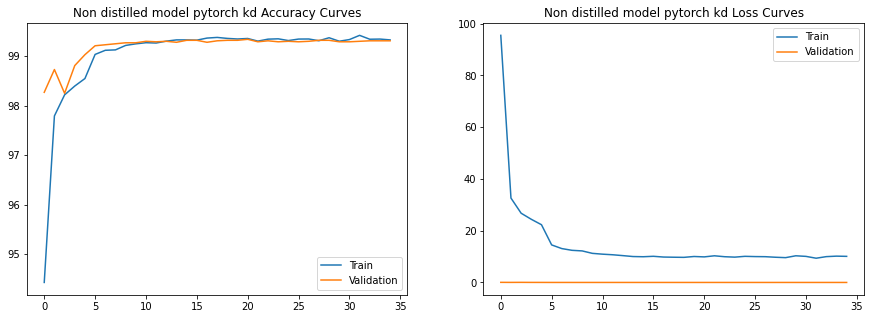

In [ ]:
plot_curves('Non distilled model pytorch kd',log = False)

#### TRAINING THE SMALLER MODEL 5K PARAMETERS

In [ ]:
epochs = 35
optimizer = optim.Adam(cmodel.parameters(), lr = 0.01)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)
path = './quantization/pytorch_model/small_pytorch.pth'

execute_model(cmodel, save_best_model=True)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.09446567296981812 Batch_id=468 Accuracy=92.84: 100%|██████████| 469/469 [00:05<00:00, 80.10it/s]



Test set: Average loss: 0.0808, Accuracy: 9747/10000 (97.47%)

97.47 97.47


  0%|          | 0/469 [00:00<?, ?it/s]

Saving model here
EPOCH: 1


Loss=0.023354997858405113 Batch_id=468 Accuracy=97.61: 100%|██████████| 469/469 [00:05<00:00, 79.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0597, Accuracy: 9799/10000 (97.99%)

97.99 97.99
Saving model here
EPOCH: 2


Loss=0.042415399104356766 Batch_id=468 Accuracy=98.06: 100%|██████████| 469/469 [00:06<00:00, 77.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0471, Accuracy: 9853/10000 (98.53%)

98.53 98.53
Saving model here
EPOCH: 3


Loss=0.06900618225336075 Batch_id=468 Accuracy=98.25: 100%|██████████| 469/469 [00:05<00:00, 78.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0438, Accuracy: 9867/10000 (98.67%)

98.67 98.67
Saving model here
EPOCH: 4


Loss=0.05066603049635887 Batch_id=468 Accuracy=98.42: 100%|██████████| 469/469 [00:05<00:00, 78.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0368, Accuracy: 9876/10000 (98.76%)

98.76 98.76
Saving model here
EPOCH: 5


Loss=0.004923364147543907 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:05<00:00, 80.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0255, Accuracy: 9923/10000 (99.23%)

99.23 99.23
Saving model here
EPOCH: 6


Loss=0.03578788787126541 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:05<00:00, 79.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0244, Accuracy: 9922/10000 (99.22%)

99.23 99.22
EPOCH: 7


Loss=0.01682802103459835 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:05<00:00, 79.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0249, Accuracy: 9922/10000 (99.22%)

99.23 99.22
EPOCH: 8


Loss=0.03526757284998894 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:05<00:00, 78.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0238, Accuracy: 9917/10000 (99.17%)

99.23 99.17
EPOCH: 9


Loss=0.015652265399694443 Batch_id=468 Accuracy=99.07: 100%|██████████| 469/469 [00:06<00:00, 77.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0260, Accuracy: 9918/10000 (99.18%)

99.23 99.18
EPOCH: 10


Loss=0.04183236137032509 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:06<00:00, 77.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0243, Accuracy: 9920/10000 (99.20%)

99.23 99.2
EPOCH: 11


Loss=0.013374987989664078 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:06<00:00, 77.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0232, Accuracy: 9918/10000 (99.18%)

99.23 99.18
EPOCH: 12


Loss=0.03064422495663166 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:06<00:00, 77.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0227, Accuracy: 9919/10000 (99.19%)

99.23 99.19
EPOCH: 13


Loss=0.001597509253770113 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:06<00:00, 78.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0229, Accuracy: 9923/10000 (99.23%)

99.23 99.23
Saving model here
EPOCH: 14


Loss=0.03041328489780426 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:05<00:00, 78.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0225, Accuracy: 9924/10000 (99.24%)

99.24 99.24
Saving model here
EPOCH: 15


Loss=0.008930002339184284 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:05<00:00, 78.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0224, Accuracy: 9921/10000 (99.21%)

99.24 99.21
EPOCH: 16


Loss=0.07730167359113693 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:06<00:00, 78.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0226, Accuracy: 9924/10000 (99.24%)

99.24 99.24
Saving model here
EPOCH: 17


Loss=0.004209389444440603 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:05<00:00, 78.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0225, Accuracy: 9922/10000 (99.22%)

99.24 99.22
EPOCH: 18


Loss=0.009869230911135674 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:05<00:00, 78.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0228, Accuracy: 9921/10000 (99.21%)

99.24 99.21
EPOCH: 19


Loss=0.004959889221936464 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:05<00:00, 79.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0226, Accuracy: 9924/10000 (99.24%)

99.24 99.24
Saving model here
EPOCH: 20


Loss=0.02059474028646946 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:06<00:00, 77.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0227, Accuracy: 9922/10000 (99.22%)

99.24 99.22
EPOCH: 21


Loss=0.012588709592819214 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:05<00:00, 78.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0222, Accuracy: 9927/10000 (99.27%)

99.27 99.27
Saving model here
EPOCH: 22


Loss=0.026391394436359406 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:06<00:00, 77.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0226, Accuracy: 9921/10000 (99.21%)

99.27 99.21
EPOCH: 23


Loss=0.02151159942150116 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:05<00:00, 78.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0226, Accuracy: 9927/10000 (99.27%)

99.27 99.27
Saving model here
EPOCH: 24


Loss=0.02412646822631359 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:05<00:00, 78.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0224, Accuracy: 9927/10000 (99.27%)

99.27 99.27
Saving model here
EPOCH: 25


Loss=0.03053220361471176 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:06<00:00, 77.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0225, Accuracy: 9925/10000 (99.25%)

99.27 99.25
EPOCH: 26


Loss=0.012529429979622364 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:05<00:00, 78.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0230, Accuracy: 9923/10000 (99.23%)

99.27 99.23
EPOCH: 27


Loss=0.026365546509623528 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:06<00:00, 77.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0229, Accuracy: 9922/10000 (99.22%)

99.27 99.22
EPOCH: 28


Loss=0.005559570621699095 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:06<00:00, 77.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0228, Accuracy: 9921/10000 (99.21%)

99.27 99.21
EPOCH: 29


Loss=0.04071180894970894 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:05<00:00, 78.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0227, Accuracy: 9922/10000 (99.22%)

99.27 99.22
EPOCH: 30


Loss=0.056327540427446365 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:06<00:00, 76.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0227, Accuracy: 9923/10000 (99.23%)

99.27 99.23
EPOCH: 31


Loss=0.004104877822101116 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:06<00:00, 76.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0228, Accuracy: 9925/10000 (99.25%)

99.27 99.25
EPOCH: 32


Loss=0.019914666190743446 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:06<00:00, 77.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0227, Accuracy: 9921/10000 (99.21%)

99.27 99.21
EPOCH: 33


Loss=0.006134682800620794 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:06<00:00, 77.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0224, Accuracy: 9925/10000 (99.25%)

99.27 99.25
EPOCH: 34


Loss=0.005547244567424059 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:06<00:00, 77.73it/s]



Test set: Average loss: 0.0226, Accuracy: 9921/10000 (99.21%)

99.27 99.21


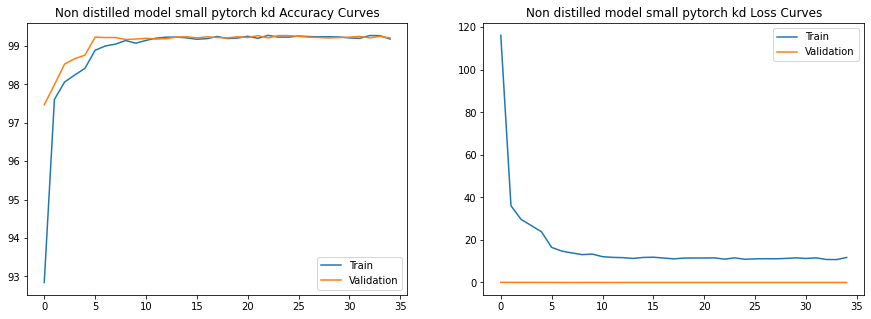

In [ ]:
plot_curves('Non distilled model small pytorch kd',log = False)

#### SUMMARY OF THE MODELS

In [ ]:
summary(model, input_size=(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
            Conv2d-4           [-1, 12, 24, 24]             864
              ReLU-5           [-1, 12, 24, 24]               0
       BatchNorm2d-6           [-1, 12, 24, 24]              24
           Dropout-7           [-1, 12, 24, 24]               0
            Conv2d-8            [-1, 8, 24, 24]              96
         MaxPool2d-9            [-1, 8, 12, 12]               0
           Conv2d-10           [-1, 12, 10, 10]             864
             ReLU-11           [-1, 12, 10, 10]               0
      BatchNorm2d-12           [-1, 12, 10, 10]              24
           Conv2d-13             [-1, 16, 8, 8]           1,728
             ReLU-14             [-1, 1

In [ ]:
summary(cmodel, input_size=(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
            Conv2d-4           [-1, 12, 24, 24]             864
              ReLU-5           [-1, 12, 24, 24]               0
       BatchNorm2d-6           [-1, 12, 24, 24]              24
           Dropout-7           [-1, 12, 24, 24]               0
            Conv2d-8            [-1, 8, 24, 24]              96
         MaxPool2d-9            [-1, 8, 12, 12]               0
           Conv2d-10           [-1, 12, 10, 10]             864
             ReLU-11           [-1, 12, 10, 10]               0
      BatchNorm2d-12           [-1, 12, 10, 10]              24
           Conv2d-13             [-1, 16, 8, 8]           1,728
             ReLU-14             [-1, 1

In [ ]:
smodel = SNet().to("cuda")
summary(smodel, input_size=(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
            Conv2d-4            [-1, 8, 24, 24]              72
            Conv2d-5           [-1, 12, 24, 24]              96
              ReLU-6           [-1, 12, 24, 24]               0
       BatchNorm2d-7           [-1, 12, 24, 24]              24
           Dropout-8           [-1, 12, 24, 24]               0
            Conv2d-9            [-1, 8, 24, 24]              96
        MaxPool2d-10            [-1, 8, 12, 12]               0
           Conv2d-11            [-1, 8, 10, 10]              72
           Conv2d-12           [-1, 12, 10, 10]              96
             ReLU-13           [-1, 12, 10, 10]               0
      BatchNorm2d-14           [-1, 12,

#### TRAINING THE SMALLEST MODEL


In [ ]:
epochs = 45
optimizer = optim.Adam(smodel.parameters(), lr = 0.01)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)
path = './quantization/pytorch_model/smallest_pytorch.pth'

execute_model(smodel, save_best_model=True)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.15798884630203247 Batch_id=468 Accuracy=87.20: 100%|██████████| 469/469 [00:06<00:00, 72.15it/s]



Test set: Average loss: 0.1306, Accuracy: 9607/10000 (96.07%)

96.07 96.07


  0%|          | 0/469 [00:00<?, ?it/s]

Saving model here
EPOCH: 1


Loss=0.09820634126663208 Batch_id=468 Accuracy=95.73: 100%|██████████| 469/469 [00:06<00:00, 73.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0822, Accuracy: 9754/10000 (97.54%)

97.54 97.54
Saving model here
EPOCH: 2


Loss=0.07025573402643204 Batch_id=468 Accuracy=96.48: 100%|██████████| 469/469 [00:06<00:00, 73.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0707, Accuracy: 9789/10000 (97.89%)

97.89 97.89
Saving model here
EPOCH: 3


Loss=0.027657246217131615 Batch_id=468 Accuracy=96.86: 100%|██████████| 469/469 [00:06<00:00, 73.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0937, Accuracy: 9715/10000 (97.15%)

97.89 97.15
EPOCH: 4


Loss=0.15030448138713837 Batch_id=468 Accuracy=97.16: 100%|██████████| 469/469 [00:06<00:00, 72.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1621, Accuracy: 9501/10000 (95.01%)

97.89 95.01
EPOCH: 5


Loss=0.018971065059304237 Batch_id=468 Accuracy=97.79: 100%|██████████| 469/469 [00:06<00:00, 71.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0563, Accuracy: 9827/10000 (98.27%)

98.27 98.27
Saving model here
EPOCH: 6


Loss=0.1197003424167633 Batch_id=468 Accuracy=98.01: 100%|██████████| 469/469 [00:06<00:00, 72.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0568, Accuracy: 9815/10000 (98.15%)

98.27 98.15
EPOCH: 7


Loss=0.1378924399614334 Batch_id=468 Accuracy=98.04: 100%|██████████| 469/469 [00:06<00:00, 72.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0537, Accuracy: 9824/10000 (98.24%)

98.27 98.24
EPOCH: 8


Loss=0.022824766114354134 Batch_id=468 Accuracy=98.11: 100%|██████████| 469/469 [00:06<00:00, 73.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0505, Accuracy: 9833/10000 (98.33%)

98.33 98.33
Saving model here
EPOCH: 9


Loss=0.04131004586815834 Batch_id=468 Accuracy=98.11: 100%|██████████| 469/469 [00:06<00:00, 74.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0566, Accuracy: 9819/10000 (98.19%)

98.33 98.19
EPOCH: 10


Loss=0.14453639090061188 Batch_id=468 Accuracy=98.17: 100%|██████████| 469/469 [00:06<00:00, 71.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0507, Accuracy: 9831/10000 (98.31%)

98.33 98.31
EPOCH: 11


Loss=0.12441956996917725 Batch_id=468 Accuracy=98.20: 100%|██████████| 469/469 [00:06<00:00, 72.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0495, Accuracy: 9834/10000 (98.34%)

98.34 98.34
Saving model here
EPOCH: 12


Loss=0.017521025612950325 Batch_id=468 Accuracy=98.28: 100%|██████████| 469/469 [00:06<00:00, 73.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0489, Accuracy: 9831/10000 (98.31%)

98.34 98.31
EPOCH: 13


Loss=0.05944423750042915 Batch_id=468 Accuracy=98.28: 100%|██████████| 469/469 [00:06<00:00, 74.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0541, Accuracy: 9817/10000 (98.17%)

98.34 98.17
EPOCH: 14


Loss=0.047038644552230835 Batch_id=468 Accuracy=98.18: 100%|██████████| 469/469 [00:06<00:00, 71.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0502, Accuracy: 9826/10000 (98.26%)

98.34 98.26
EPOCH: 15


Loss=0.08825862407684326 Batch_id=468 Accuracy=98.20: 100%|██████████| 469/469 [00:06<00:00, 69.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0509, Accuracy: 9825/10000 (98.25%)

98.34 98.25
EPOCH: 16


Loss=0.03661539405584335 Batch_id=468 Accuracy=98.21: 100%|██████████| 469/469 [00:06<00:00, 69.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0488, Accuracy: 9832/10000 (98.32%)

98.34 98.32
EPOCH: 17


Loss=0.0070854295045137405 Batch_id=468 Accuracy=98.24: 100%|██████████| 469/469 [00:06<00:00, 69.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0506, Accuracy: 9829/10000 (98.29%)

98.34 98.29
EPOCH: 18


Loss=0.03424445539712906 Batch_id=468 Accuracy=98.28: 100%|██████████| 469/469 [00:06<00:00, 69.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0496, Accuracy: 9833/10000 (98.33%)

98.34 98.33
EPOCH: 19


Loss=0.021094053983688354 Batch_id=468 Accuracy=98.29: 100%|██████████| 469/469 [00:06<00:00, 70.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0508, Accuracy: 9822/10000 (98.22%)

98.34 98.22
EPOCH: 20


Loss=0.03711361065506935 Batch_id=468 Accuracy=98.24: 100%|██████████| 469/469 [00:06<00:00, 68.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0510, Accuracy: 9817/10000 (98.17%)

98.34 98.17
EPOCH: 21


Loss=0.10340180993080139 Batch_id=468 Accuracy=98.25: 100%|██████████| 469/469 [00:06<00:00, 68.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0497, Accuracy: 9825/10000 (98.25%)

98.34 98.25
EPOCH: 22


Loss=0.04739416763186455 Batch_id=468 Accuracy=98.28: 100%|██████████| 469/469 [00:06<00:00, 67.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0505, Accuracy: 9830/10000 (98.30%)

98.34 98.3
EPOCH: 23


Loss=0.09937053918838501 Batch_id=468 Accuracy=98.28: 100%|██████████| 469/469 [00:06<00:00, 69.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0510, Accuracy: 9826/10000 (98.26%)

98.34 98.26
EPOCH: 24


Loss=0.03154401853680611 Batch_id=468 Accuracy=98.22: 100%|██████████| 469/469 [00:06<00:00, 69.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0484, Accuracy: 9835/10000 (98.35%)

98.35 98.35
Saving model here
EPOCH: 25


Loss=0.08819445967674255 Batch_id=468 Accuracy=98.26: 100%|██████████| 469/469 [00:06<00:00, 68.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0484, Accuracy: 9832/10000 (98.32%)

98.35 98.32
EPOCH: 26


Loss=0.03956739977002144 Batch_id=468 Accuracy=98.28: 100%|██████████| 469/469 [00:06<00:00, 69.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0492, Accuracy: 9833/10000 (98.33%)

98.35 98.33
EPOCH: 27


Loss=0.014593455940485 Batch_id=468 Accuracy=98.19: 100%|██████████| 469/469 [00:06<00:00, 69.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0502, Accuracy: 9831/10000 (98.31%)

98.35 98.31
EPOCH: 28


Loss=0.058629006147384644 Batch_id=468 Accuracy=98.27: 100%|██████████| 469/469 [00:06<00:00, 67.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0503, Accuracy: 9825/10000 (98.25%)

98.35 98.25
EPOCH: 29


Loss=0.0861096978187561 Batch_id=468 Accuracy=98.25: 100%|██████████| 469/469 [00:06<00:00, 68.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0507, Accuracy: 9833/10000 (98.33%)

98.35 98.33
EPOCH: 30


Loss=0.05943761765956879 Batch_id=468 Accuracy=98.18: 100%|██████████| 469/469 [00:07<00:00, 66.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0519, Accuracy: 9823/10000 (98.23%)

98.35 98.23
EPOCH: 31


Loss=0.06739216297864914 Batch_id=468 Accuracy=98.25: 100%|██████████| 469/469 [00:06<00:00, 67.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0498, Accuracy: 9833/10000 (98.33%)

98.35 98.33
EPOCH: 32


Loss=0.03055771254003048 Batch_id=468 Accuracy=98.19: 100%|██████████| 469/469 [00:07<00:00, 66.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0519, Accuracy: 9828/10000 (98.28%)

98.35 98.28
EPOCH: 33


Loss=0.03881645202636719 Batch_id=468 Accuracy=98.24: 100%|██████████| 469/469 [00:06<00:00, 67.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0502, Accuracy: 9832/10000 (98.32%)

98.35 98.32
EPOCH: 34


Loss=0.18464259803295135 Batch_id=468 Accuracy=98.25: 100%|██████████| 469/469 [00:06<00:00, 67.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0502, Accuracy: 9831/10000 (98.31%)

98.35 98.31
EPOCH: 35


Loss=0.22321484982967377 Batch_id=468 Accuracy=98.22: 100%|██████████| 469/469 [00:07<00:00, 66.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0520, Accuracy: 9822/10000 (98.22%)

98.35 98.22
EPOCH: 36


Loss=0.07520019263029099 Batch_id=468 Accuracy=98.26: 100%|██████████| 469/469 [00:07<00:00, 66.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0522, Accuracy: 9824/10000 (98.24%)

98.35 98.24
EPOCH: 37


Loss=0.0369681790471077 Batch_id=468 Accuracy=98.19: 100%|██████████| 469/469 [00:07<00:00, 66.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0519, Accuracy: 9828/10000 (98.28%)

98.35 98.28
EPOCH: 38


Loss=0.19690637290477753 Batch_id=468 Accuracy=98.27: 100%|██████████| 469/469 [00:06<00:00, 67.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0501, Accuracy: 9826/10000 (98.26%)

98.35 98.26
EPOCH: 39


Loss=0.03792605549097061 Batch_id=468 Accuracy=98.26: 100%|██████████| 469/469 [00:06<00:00, 68.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0505, Accuracy: 9827/10000 (98.27%)

98.35 98.27
EPOCH: 40


Loss=0.03321969136595726 Batch_id=468 Accuracy=98.29: 100%|██████████| 469/469 [00:07<00:00, 66.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0511, Accuracy: 9821/10000 (98.21%)

98.35 98.21
EPOCH: 41


Loss=0.02005787193775177 Batch_id=468 Accuracy=98.22: 100%|██████████| 469/469 [00:07<00:00, 66.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0496, Accuracy: 9827/10000 (98.27%)

98.35 98.27
EPOCH: 42


Loss=0.08023051172494888 Batch_id=468 Accuracy=98.23: 100%|██████████| 469/469 [00:07<00:00, 66.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0495, Accuracy: 9826/10000 (98.26%)

98.35 98.26
EPOCH: 43


Loss=0.03821147233247757 Batch_id=468 Accuracy=98.32: 100%|██████████| 469/469 [00:07<00:00, 65.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0520, Accuracy: 9827/10000 (98.27%)

98.35 98.27
EPOCH: 44


Loss=0.057417307049036026 Batch_id=468 Accuracy=98.27: 100%|██████████| 469/469 [00:06<00:00, 67.64it/s]



Test set: Average loss: 0.0491, Accuracy: 9829/10000 (98.29%)

98.35 98.29
